## Step 1 — Project setup & dataset overview
### Step 1A — Paths & folders

In [4]:
# =========================================
# Step 1A — Paths & folders
# (matches your original "Cell 1: paths & folders")
# =========================================
from pathlib import Path

# 👉 EDIT THIS if your dataset lives somewhere else
DATA_ROOT = Path(r"C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025")

# Classification dirs
CLS_TRAIN = DATA_ROOT / "classification_task" / "train"
CLS_TEST  = DATA_ROOT / "classification_task" / "test"

# Segmentation dirs
SEG_TRN_I = DATA_ROOT / "segmentation_task" / "train" / "images"
SEG_TRN_M = DATA_ROOT / "segmentation_task" / "train" / "masks"
SEG_TST_I = DATA_ROOT / "segmentation_task" / "test"  / "images"
SEG_TST_M = DATA_ROOT / "segmentation_task" / "test"  / "masks"

# Artifacts (local)
MODELS_DIR  = Path("./models");  MODELS_DIR.mkdir(exist_ok=True, parents=True)
OUTPUTS_DIR = Path("./outputs"); OUTPUTS_DIR.mkdir(exist_ok=True, parents=True)
(OUTPUTS_DIR / "overlays").mkdir(exist_ok=True, parents=True)

print("DATA_ROOT:", DATA_ROOT)
for p in [CLS_TRAIN, CLS_TEST, SEG_TRN_I, SEG_TRN_M, SEG_TST_I, SEG_TST_M]:
    print(p, "exists:", p.exists())


DATA_ROOT: C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025
C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\classification_task\train exists: True
C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\classification_task\test exists: True
C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\segmentation_task\train\images exists: True
C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\segmentation_task\train\masks exists: True
C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\segmentation_task\test\images exists: True
C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\segmentation_task\test\masks exists: True


### Step 1B — Dataset overview (class distribution + sample gallery)

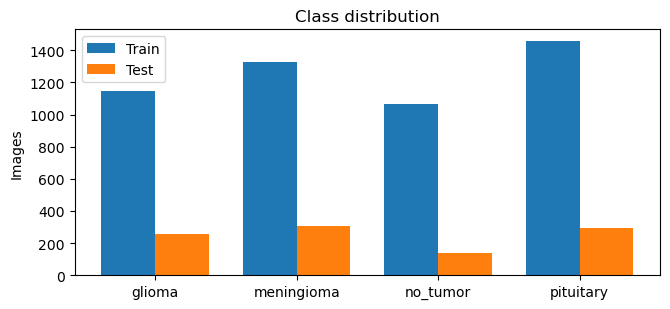

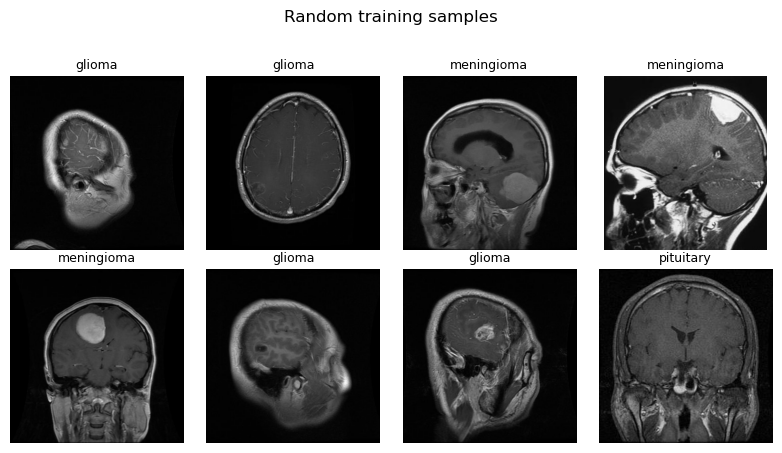

In [5]:
# =========================================
# Step 1B — Dataset overview: class distribution + sample gallery
# (matches your original "A) Dataset overview")
# =========================================
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np, random

IMG_EXTS = {".png",".jpg",".jpeg"}

def count_images_per_class(root: Path):
    root = Path(root)
    counts = {}
    for cls_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        n = sum(1 for p in cls_dir.rglob("*") if p.suffix.lower() in IMG_EXTS)
        counts[cls_dir.name] = n
    return counts

tr_counts = count_images_per_class(CLS_TRAIN)
ts_counts = count_images_per_class(CLS_TEST)

# Bar chart (train vs test)
classes = sorted(set(tr_counts) | set(ts_counts))
x = np.arange(len(classes)); w = 0.38
plt.figure(figsize=(6.8,3.2))
plt.bar(x-w/2, [tr_counts.get(c,0) for c in classes], width=w, label="Train")
plt.bar(x+w/2, [ts_counts.get(c,0) for c in classes], width=w, label="Test")
plt.xticks(x, classes); plt.ylabel("Images")
plt.title("Class distribution"); plt.legend(); plt.tight_layout(); plt.show()

# Small gallery (8 random images from train)
all_imgs = [p for p in Path(CLS_TRAIN).rglob("*") if p.suffix.lower() in IMG_EXTS]
sampled = random.sample(all_imgs, min(8, len(all_imgs)))
cols = 4; rows = int(np.ceil(len(sampled)/cols))
plt.figure(figsize=(8, 2.2*rows))
for i,p in enumerate(sampled):
    ax = plt.subplot(rows, cols, i+1); ax.axis("off")
    ax.set_title(p.parent.name, fontsize=9)
    try: ax.imshow(Image.open(p).convert("RGB"))
    except: ax.text(0.5,0.5,"<unreadable>", ha="center", va="center")
plt.suptitle("Random training samples", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()


### Step 1C — Environment & config

In [6]:
# =========================================
# Step 1C — Environment & config
# (imports, device, seeds, minimal requirements)
# =========================================
import os, json, re, hashlib, shutil, math, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw
from datetime import datetime

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
import scipy.ndimage as ndi

# PDF utilities
from reportlab.lib.pagesizes import A4
from reportlab.lib.utils import ImageReader
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from matplotlib.table import Table
from collections import Counter, defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

random.seed(42); np.random.seed(42); torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Keep a minimal requirements list (handy for reproducibility)
with open("requirements.txt","w") as f:
    f.write("\n".join([
        "torch", "torchvision", "numpy", "pillow", "scikit-learn",
        "matplotlib", "reportlab", "tqdm", "scipy", "pandas"
    ]))
print("Wrote basic requirements.txt")


Using device: cpu
Wrote basic requirements.txt


### Step 1D — Leakage check (optional; safe to run once)

In [7]:
# =========================================
# Step 1D — Leakage check (optional)
# (matches your original "Cell 3: leakage check")
# =========================================
def md5(p: Path):
    h = hashlib.md5()
    with open(p,'rb') as f:
        for chunk in iter(lambda: f.read(8192), b''): h.update(chunk)
    return h.hexdigest()

def all_image_paths(root: Path):
    exts = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
    return [p for p in root.rglob("*") if p.suffix.lower() in exts]

LEAK_BIN = DATA_ROOT / "classification_task" / "_leakage_quarantined"
LEAK_BIN.mkdir(parents=True, exist_ok=True)

train_imgs = all_image_paths(CLS_TRAIN)
test_imgs  = all_image_paths(CLS_TEST)
train_hashes = {md5(p): p for p in train_imgs}

dupes = []
for p in test_imgs:
    h = md5(p)
    if h in train_hashes:
        dupes.append((train_hashes[h], p))

print(f"Found duplicates: {len(dupes)}")
for i,(tr,te) in enumerate(dupes,1):
    dst = LEAK_BIN / te.name
    shutil.move(str(te), dst)
    print(f"{i:02d} moved test→bin:", te, "→", dst)


Found duplicates: 0


## Step 2 — Classification (ResNet-50): dataloaders → train → evaluate → save artifacts

#### Step 2A — Dataloaders (train/test)

In [8]:
# =========================================
# Step 2A — Dataloaders (classification)
# =========================================
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def make_classification_dls(train_dir, test_dir, img_size=224, bs=32, workers=0):
    aug = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    eval_tfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    tr = ImageFolder(str(train_dir), aug)
    te = ImageFolder(str(test_dir),  eval_tfm)
    tr_dl = DataLoader(tr, batch_size=bs, shuffle=True,  num_workers=workers, pin_memory=False)
    te_dl = DataLoader(te, batch_size=bs, shuffle=False, num_workers=workers, pin_memory=False)
    print("Detected classes:", tr.classes)  # e.g., ['glioma','meningioma','no_tumor','pituitary']
    return tr_dl, te_dl, tr.classes


#### Step 2B — Model builder (ResNet-50, partial freezing)

In [9]:
# =========================================
# Step 2B — Model builder (ResNet-50)
# =========================================
import torch.nn as nn
from torchvision import models

def build_classifier(num_classes, freeze_until='layer3'):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    freeze_names = []
    if freeze_until == 'layer3': freeze_names = ['conv1','bn1','layer1','layer2']
    elif freeze_until == 'layer2': freeze_names = ['conv1','bn1','layer1']
    for name, p in m.named_parameters():
        p.requires_grad = not any(name.startswith(fn) for fn in freeze_names)
    return m


#### Step 2C — Train (early stopping on accuracy)

In [10]:
# =========================================
# Step 2C — Train ResNet-50 (early stop)
# =========================================
import torch
import torch.nn as nn
from tqdm import tqdm

@torch.no_grad()
def eval_classifier(model, dl):
    model.eval()
    preds, tgts = [], []
    for xb, yb in dl:
        xb = xb.to(device)
        pr = model(xb).argmax(1).cpu().numpy()
        preds.append(pr); tgts.append(yb.numpy())
    y_true = np.concatenate(tgts); y_pred = np.concatenate(preds)
    return y_true, y_pred

def train_classifier(
    train_dir, test_dir, *, img_size=224, bs=32, workers=0, epochs=10,
    base_lr=3e-4, wd=1e-4, freeze_until='layer3',
    ckpt_out=MODELS_DIR / "classifier_resnet50.pt",
    patience=1, target_acc=0.95, min_epochs=2
):
    tr_dl, te_dl, classes = make_classification_dls(train_dir, test_dir, img_size, bs, workers)
    m = build_classifier(len(classes), freeze_until).to(device)
    back_params, head_params = [], []
    for n,p in m.named_parameters():
        (head_params if n.startswith("fc") else back_params).append(p)
    opt = torch.optim.AdamW([
        {"params": back_params, "lr": base_lr},
        {"params": head_params, "lr": base_lr*3},
    ], weight_decay=wd)
    crit = nn.CrossEntropyLoss(label_smoothing=0.05)

    best_acc = 0.0; patience_counter = 0
    for ep in range(1, epochs+1):
        m.train()
        for xb,yb in tqdm(tr_dl, desc=f"[CLS] epoch {ep}/{epochs}", leave=False):
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            loss = crit(m(xb), yb)
            loss.backward(); opt.step()

        y_true, y_pred = eval_classifier(m, te_dl)
        acc = float((y_true == y_pred).mean())
        print(f"[CLS] Epoch {ep}: val acc={acc:.4f}")

        if acc > best_acc + 1e-6:
            best_acc = acc
            torch.save({"model": m.state_dict(), "classes": classes}, ckpt_out)
            patience_counter = 0
        else:
            patience_counter += 1

        if ep >= min_epochs and target_acc is not None and acc >= target_acc:
            print(f"[CLS] Target accuracy {target_acc:.3f} reached at epoch {ep}.")
            break
        if ep >= min_epochs and patience_counter >= patience:
            print(f"[CLS] Early stopping at epoch {ep} (best val acc={best_acc:.4f})")
            break

    print(f"[CLS] Best val acc: {best_acc:.4f}; saved to {ckpt_out}")
    return ckpt_out

# --- Run training (fresh run) ---
RUN_TRAIN_CLS = True
ckpt_clf = train_classifier(
    CLS_TRAIN, CLS_TEST,
    img_size=224, bs=32, workers=0, epochs=10,
    base_lr=3e-4, freeze_until='layer3',
    ckpt_out=MODELS_DIR / "classifier_resnet50.pt",
    patience=1, target_acc=0.95, min_epochs=2
) if RUN_TRAIN_CLS else (MODELS_DIR / "classifier_resnet50.pt")
print("Using classifier:", ckpt_clf, ckpt_clf.exists())


Detected classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


[CLS] Epoch 1: val acc=0.9648


[CLS] Epoch 2: val acc=0.9879
[CLS] Target accuracy 0.950 reached at epoch 2.
[CLS] Best val acc: 0.9879; saved to models\classifier_resnet50.pt
Using classifier: models\classifier_resnet50.pt True


#### Step 2D — Evaluate on test + save artifacts (JSON/CSV/PNG)

In [11]:
# =========================================
# Step 2D — Evaluate & export artifacts
# (Confusion matrix visual; per-class CSV; presence metric)
# =========================================
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Load best checkpoint
state = torch.load(ckpt_clf, map_location="cpu")
classes = state["classes"]
clf_model = build_classifier(len(classes)).to(device)
clf_model.load_state_dict(state["model"]); clf_model.eval()

# Get test loader and predictions
_, test_dl, _ = make_classification_dls(CLS_TRAIN, CLS_TEST, img_size=224, bs=32, workers=0)
y_true, y_pred = eval_classifier(clf_model, test_dl)
acc = float((y_true == y_pred).mean())
print("[CLS] Test accuracy:", acc)

# Save summary JSON
with open(OUTPUTS_DIR / "clf_report.json", "w") as f:
    json.dump({"accuracy": acc}, f)

# Confusion matrix (VISUAL)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
fig, ax = plt.subplots(figsize=(5.2,5.2))
ConfusionMatrixDisplay(cm, display_labels=classes).plot(ax=ax, cmap="viridis", colorbar=True, xticks_rotation=45)
plt.title("Confusion Matrix (test)")
plt.tight_layout(); plt.savefig(OUTPUTS_DIR / "clf_confusion.png", dpi=150); plt.close(fig)

# Per-class metrics CSV
rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
pd.DataFrame(rep).transpose().to_csv(OUTPUTS_DIR / "clf_per_class_metrics.csv", index=True)

# Presence detection (binary) derived from multi-class: tumor_present ≡ class != "no_tumor"
if "no_tumor" in classes:
    idx_no = classes.index("no_tumor")
    y_true_bin = (y_true != idx_no).astype(int)
    y_pred_bin = (y_pred != idx_no).astype(int)
    acc_bin = float((y_true_bin == y_pred_bin).mean())
    with open(OUTPUTS_DIR / "clf_presence_report.json","w") as f:
        json.dump({"binary_presence_accuracy": acc_bin}, f)
    print(f"[CLS] Binary tumor presence accuracy: {acc_bin:.4f}")
else:
    print("[CLS] NOTE: 'no_tumor' class not found — binary presence metric skipped.")


Detected classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
[CLS] Test accuracy: 0.9879154078549849
[CLS] Binary tumor presence accuracy: 1.0000


## Step 3 — Segmentation (U-Net), threshold tuning, overlays & staging

#### Step 3A — Dataset (robust pairing)

In [12]:
# =========================================
# Step 3A — Segmentation dataset (robust pairing)
# =========================================
class SegDataset(Dataset):
    IMG_EXTS  = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
    MASK_EXTS = {".png",".jpg",".jpeg"}
    def __init__(self, img_dir: Path, mask_dir: Path, img_size=192, aug=True, verbose=True):
        self.img_dir, self.mask_dir = Path(img_dir), Path(mask_dir)
        self.img_size, self.aug = img_size, aug
        imgs = [p for p in self.img_dir.iterdir() if p.is_file() and p.suffix.lower() in self.IMG_EXTS]
        self.pairs = []
        for ip in sorted(imgs):
            mp = self._find_mask_for(ip)
            if mp is not None: self.pairs.append((ip, mp))
        if verbose: print(f"[SegDataset] {len(self.pairs)} pairs")
        self.tfm_img = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip() if aug else transforms.Lambda(lambda x: x),
            transforms.ToTensor()
        ])
    def _find_mask_for(self, ip: Path):
        mp = self.mask_dir / ip.name
        if mp.exists(): return mp
        stem = ip.stem
        for ext in self.MASK_EXTS:
            cand = self.mask_dir / f"{stem}{ext}"
            if cand.exists(): return cand
        for ext in self.MASK_EXTS:
            cand = self.mask_dir / f"{stem}_mask{ext}"
            if cand.exists(): return cand
        return None
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img  = Image.open(ip).convert("RGB")
        mask = Image.open(mp).convert("L")
        img  = self.tfm_img(img)
        mask = ImageOps.fit(mask, (self.img_size, self.img_size), method=Image.NEAREST)
        mask = torch.from_numpy((np.array(mask) > 127).astype(np.float32)).unsqueeze(0)
        return img, mask, ip.name


#### Step 3B — U-Net model

In [13]:
# =========================================
# Step 3B — U-Net model
# =========================================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch,out_ch,3,padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True),
        )
    def forward(self,x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32, depth=5):
        super().__init__()
        chans = [base*(2**i) for i in range(depth)]
        self.enc = nn.ModuleList([DoubleConv(in_ch, chans[0])])
        self.pool = nn.ModuleList()
        for i in range(depth-1):
            self.pool.append(nn.MaxPool2d(2))
            self.enc.append(DoubleConv(chans[i], chans[i+1]))
        self.up  = nn.ModuleList()
        self.dec = nn.ModuleList()
        for i in reversed(range(depth-1)):
            self.up.append(nn.ConvTranspose2d(chans[i+1], chans[i], 2, 2))
            self.dec.append(DoubleConv(chans[i]*2, chans[i]))
        self.head = nn.Conv2d(chans[0], out_ch, 1)
    def forward(self, x):
        skips = []
        for i, blk in enumerate(self.enc):
            x = blk(x)
            if i < len(self.pool):
                skips.append(x); x = self.pool[i](x)
        for i in range(len(self.up)):
            x = self.up[i](x)
            skip = skips[-(i+1)]
            if x.shape[-2:] != skip.shape[-2:]:
                dy = skip.shape[-2] - x.shape[-2]
                dx = skip.shape[-1] - x.shape[-1]
                x = F.pad(x, [dx//2, dx-dx//2, dy//2, dy-dy//2])
            x = self.dec[i](torch.cat([skip, x], dim=1))
        return self.head(x)


#### Step 3C — Train U-Net (Dice + BCE, early stop)

In [14]:
# =========================================
# Step 3C — Train UNet (Dice + BCE, early stop)
# =========================================
def dice_coeff(pred, target, eps=1e-6):
    num = 2*(pred*target).sum(dim=(1,2,3))
    den = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps
    return (num/den).mean().item()

def train_unet(
    img_dir_trn, mask_dir_trn, img_dir_tst, mask_dir_tst, *,
    img_size=192, bs=8, workers=0, epochs=12, lr=3e-4, depth=5,
    ckpt_out=MODELS_DIR/"unet_deeper.pt", patience=2, target_dice=0.40, min_epochs=2
):
    trn = SegDataset(img_dir_trn, mask_dir_trn, img_size=img_size, aug=True,  verbose=False)
    tst = SegDataset(img_dir_tst, mask_dir_tst, img_size=img_size, aug=False, verbose=False)
    trn_dl = DataLoader(trn, batch_size=bs, shuffle=True,  num_workers=workers, pin_memory=False)
    tst_dl = DataLoader(tst, batch_size=bs, shuffle=False, num_workers=workers, pin_memory=False)

    m = UNet(3,1,base=32,depth=depth).to(device)
    opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=1e-4)
    bce = nn.BCEWithLogitsLoss()

    best, bad = 0.0, 0
    for ep in range(1, epochs+1):
        m.train()
        for xb,yb,_ in tqdm(trn_dl, desc=f"[UNet] {ep}/{epochs}", leave=False):
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = m(xb)
            p = torch.sigmoid(logits)
            num = 2*(p*yb).sum(dim=(1,2,3))
            den = p.sum(dim=(1,2,3)) + yb.sum(dim=(1,2,3)) + 1e-6
            loss = 0.5*(1 - (num/den).mean()) + 0.5*bce(logits,yb)
            loss.backward(); opt.step()

        m.eval(); v_dice=0.0; n=0
        with torch.no_grad():
            for xb,yb,_ in tst_dl:
                xb,yb = xb.to(device), yb.to(device)
                pr = (torch.sigmoid(m(xb))>0.5).float()
                v_dice += dice_coeff(pr,yb)*xb.size(0); n += xb.size(0)
        vD = v_dice/max(1,n)
        print(f"[UNet] Epoch {ep}: val Dice={vD:.3f}")

        if vD > best:
            best = vD; bad = 0
            torch.save(m.state_dict(), ckpt_out)
        else:
            bad += 1

        if ep >= min_epochs and target_dice is not None and vD >= target_dice:
            print(f"[UNet] Target Dice {target_dice:.3f} reached at epoch {ep}."); break
        if bad >= patience:
            print(f"[UNet] Early stopping at epoch {ep} (best={best:.3f})."); break

    print(f"[UNet] Best val Dice={best:.3f}; saved to {ckpt_out}")
    return ckpt_out, best

RUN_TRAIN_UNET = True  # retrain for a fresh run
ckpt_unet, best_dice = train_unet(
    SEG_TRN_I, SEG_TRN_M, SEG_TST_I, SEG_TST_M,
    img_size=192, bs=8, workers=0, epochs=12, depth=5, lr=3e-4,
    ckpt_out=MODELS_DIR / "unet_deeper.pt", patience=2, target_dice=0.40, min_epochs=2
) if RUN_TRAIN_UNET else (MODELS_DIR / "unet_deeper.pt", None)
print("Using UNet:", ckpt_unet, ckpt_unet.exists())


[UNet] Epoch 1: val Dice=0.221


[UNet] Epoch 2: val Dice=0.381


[UNet] Epoch 3: val Dice=0.379


[UNet] Epoch 4: val Dice=0.532
[UNet] Target Dice 0.400 reached at epoch 4.
[UNet] Best val Dice=0.532; saved to models\unet_deeper.pt
Using UNet: models\unet_deeper.pt True


#### Step 3D — Quick Binary Classification (presence) training

In [15]:
# =========================================
# Step 3D — Quick Binary Classification (Tumor Presence)
# =========================================
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from pathlib import Path
import numpy as np
from tqdm import tqdm

# Paths
DATA_ROOT = Path(r"C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025")
CLS_TRAIN = DATA_ROOT / "classification_task" / "train"
CLS_TEST  = DATA_ROOT / "classification_task" / "test"
MODELS_DIR = DATA_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True, parents=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap dataset → no_tumor=0, others=1
class BinaryWrapper(Dataset):
    def __init__(self, base_ds: ImageFolder, no_tumor_label="no_tumor"):
        self.base = base_ds
        self.no_tumor_idx = base_ds.class_to_idx[no_tumor_label]
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        x,y = self.base[idx]
        return x, 0 if y==self.no_tumor_idx else 1

# Transforms
tfm_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
tfm_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# Build datasets
train_ds = BinaryWrapper(ImageFolder(str(CLS_TRAIN), transform=tfm_train))
test_ds  = BinaryWrapper(ImageFolder(str(CLS_TEST),  transform=tfm_eval))
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=16, shuffle=False)

# Model
def build_binary_resnet():
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    m.fc = nn.Linear(m.fc.in_features, 2)
    return m.to(device)

# Quick training loop (only 2 epochs)
def train_binary_quick(epochs=2, lr=3e-4, ckpt_out=MODELS_DIR/"classifier_binary_resnet50.pt"):
    m = build_binary_resnet()
    opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()
    best_acc = 0.0
    for ep in range(1, epochs+1):
        m.train()
        for xb,yb in tqdm(train_dl, desc=f"Epoch {ep}/{epochs}", leave=False):
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            loss = crit(m(xb), yb); loss.backward(); opt.step()
        # Validation
        m.eval(); correct, total = 0,0
        with torch.no_grad():
            for xb,yb in test_dl:
                xb,yb = xb.to(device), yb.to(device)
                pred = m(xb).argmax(1)
                correct += (pred==yb).sum().item(); total += yb.size(0)
        acc = correct/total
        print(f"[Binary] Epoch {ep}: val acc={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            torch.save({"model": m.state_dict(), "classes": ["no_tumor","tumor_present"]}, ckpt_out)
            print("  Saved best →", ckpt_out)
    print("Best acc:", best_acc)

# Run quick training
train_binary_quick()


[Binary] Epoch 1: val acc=0.9889
  Saved best → C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\models\classifier_binary_resnet50.pt


[Binary] Epoch 2: val acc=0.9859
Best acc: 0.9889224572004028


#### Step 3E — Threshold tuning + post-processing (largest CC + opening)

In [16]:
# =========================================
# Step 3E — Threshold tuning + post-processing
# =========================================
VAL_IMG_DIR, VAL_MASK_DIR = SEG_TST_I, SEG_TST_M
IMG_SIZE_SEG, DEPTH_SEG, BATCH_SEG = 192, 5, 4
TAU_RANGE = (0.20, 0.80, 61)   # (start, stop, points)
_cache = OUTPUTS_DIR / "val_probs.npz"

def collect_probs_once(ckpt_path, img_dir, mask_dir, img_size=192, depth=5, batch=4):
    if _cache.exists():
        d = np.load(_cache); return d["probs"], d["masks"]
    ds = SegDataset(img_dir, mask_dir, img_size=img_size, aug=False, verbose=True)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=0, pin_memory=False)
    m = UNet(3,1,base=32,depth=depth).to(device)
    m.load_state_dict(torch.load(ckpt_path, map_location=device)); m.eval()
    P, Y = [], []
    with torch.no_grad():
        for xb, yb, _ in dl:
            xb = xb.to(device)
            P.append(torch.sigmoid(m(xb)).cpu().numpy())
            Y.append(yb.cpu().numpy())
    probs = np.concatenate(P, axis=0); masks = np.concatenate(Y, axis=0)
    np.savez_compressed(_cache, probs=probs, masks=masks)
    return probs, masks

def sweep_tau(probs, masks, tau_range=(0.2,0.8,61)):
    taus = np.linspace(*tau_range).astype(np.float32)
    pr = probs[None, ...] > taus[:, None, None, None, None]  # (T,N,1,H,W)
    y  = masks > 0.5
    tp = np.logical_and(pr, y).sum(axis=(2,3,4))
    sp = pr.sum(axis=(2,3,4)); sy = y.sum(axis=(1,2,3))[None, :]
    dice = (2.0*tp) / (sp + sy + 1e-6)
    mean_dice = dice.mean(axis=1)
    k = int(mean_dice.argmax())
    return float(taus[k]), float(mean_dice[k])

def postprocess_lcc(bin_np, do_open=True):
    lab, n = ndi.label(bin_np.astype(np.uint8))
    if n == 0: return bin_np
    sizes = ndi.sum(bin_np, lab, index=range(1, n+1))
    keep = int(np.argmax(sizes) + 1)
    out = (lab == keep).astype(np.uint8)
    if do_open: out = ndi.binary_opening(out, structure=np.ones((3,3))).astype(np.uint8)
    return out

probs, masks = collect_probs_once(ckpt_unet, VAL_IMG_DIR, VAL_MASK_DIR, img_size=IMG_SIZE_SEG, depth=DEPTH_SEG, batch=BATCH_SEG)
BEST_TAU, BEST_VAL_DICE = sweep_tau(probs, masks, tau_range=TAU_RANGE)
print(f"[UNet] Tuned threshold τ={BEST_TAU:.3f} (mean Dice≈{BEST_VAL_DICE:.3f})")


[UNet] Tuned threshold τ=0.800 (mean Dice≈0.527)


#### Step 3F — Overlays + Stage (% area) + histogram (+ stage distribution)

[Overlays]: 100%|████████████████████████████████████████████████████████████████████| 350/350 [01:36<00:00,  3.64it/s]


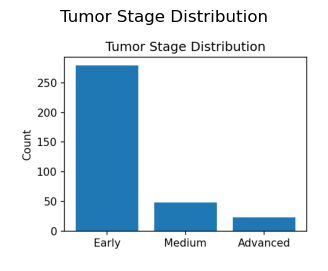

In [17]:
# =========================================
# Step 3F — Overlays + Stage + Histogram
# =========================================
def make_overlays_and_stage(ckpt_path, img_dir: Path, img_size=192, depth=5, out_dir=OUTPUTS_DIR/"overlays", tau=0.5):
    out_dir.mkdir(parents=True, exist_ok=True)
    m = UNet(3,1,base=32,depth=depth).to(device)
    m.load_state_dict(torch.load(ckpt_path, map_location=device)); m.eval()
    ds = SegDataset(img_dir, SEG_TST_M, img_size=img_size, aug=False, verbose=False)
    dl = DataLoader(ds, batch_size=1, shuffle=False)
    rows = []
    with torch.no_grad():
        for xb, _, fn in tqdm(dl, desc="[Overlays]"):
            xb = xb.to(device)
            prob = torch.sigmoid(m(xb))[0,0].cpu().numpy()
            pred = postprocess_lcc((prob > float(tau)).astype(np.uint8))
            # overlay
            ip = img_dir / fn[0]
            orig = Image.open(ip).convert("RGB").resize((img_size, img_size))
            ov = orig.copy(); dr = ImageDraw.Draw(ov, "RGBA")
            ys, xs = np.where(pred > 0.5)
            for x,y in zip(xs,ys): dr.point((x,y), fill=(255,0,0,100))
            (out_dir / f"{Path(fn[0]).stem}_overlay.jpg").write_bytes(ov.tobytes())  # ensure write? fallback below
            ov.save(out_dir / f"{Path(fn[0]).stem}_overlay.jpg", quality=90)
            perc = 100.0 * pred.mean()
            stage = "Early" if perc < 3 else "Medium" if perc < 6 else "Advanced"
            rows.append((fn[0], float(perc), stage))
    return rows

staging_stats = make_overlays_and_stage(ckpt_unet, SEG_TST_I, img_size=192, depth=5, tau=BEST_TAU)
df_stage = pd.DataFrame(staging_stats, columns=["filename","tumor_area_%","stage"])
df_stage.to_csv(OUTPUTS_DIR / "staging_summary.csv", index=False)

# Tumor size histogram (VISUAL)
def tumor_size_histogram(staging_rows, out_path=OUTPUTS_DIR/"tumor_size_hist.png"):
    percs = [float(p) for _, p, _ in staging_rows]
    fig, ax = plt.subplots(figsize=(5,3.2))
    ax.hist(percs, bins=20)
    ax.set_xlabel("Tumor area (% of image)"); ax.set_ylabel("Count")
    ax.set_title("Tumor size distribution (test)")
    plt.tight_layout(); fig.savefig(out_path, dpi=150); plt.close(fig)
    return out_path

tumor_hist_path = tumor_size_histogram(staging_stats)

# === Stage distribution preview (auto-creates if missing) ===
from IPython.display import display
import matplotlib.image as mpimg

png_path = OUTPUTS_DIR / "staging_distribution.png"
csv_path = OUTPUTS_DIR / "staging_summary.csv"

def show_png_inline(png_file: Path):
    img = mpimg.imread(png_file)
    plt.figure(figsize=(4,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Tumor Stage Distribution")
    plt.show()

if png_path.exists():
    show_png_inline(png_path)
else:
    if csv_path.exists():
        df_stage = pd.read_csv(csv_path)
    elif 'staging_stats' in globals() and staging_stats:
        df_stage = pd.DataFrame(staging_stats, columns=["filename","tumor_area_%","stage"])
    else:
        raise RuntimeError("No staging data found. Run Cell 12 first.")

    counts = (df_stage["stage"]
              .value_counts()
              .reindex(["Early","Medium","Advanced"])
              .fillna(0)
              .astype(int))

    fig, ax = plt.subplots(figsize=(4,3))
    ax.bar(counts.index, counts.values)
    ax.set_title("Tumor Stage Distribution")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    plt.show()


#### Step 3G — Segmentation comparison grid (GT vs Pred @ τ*)

In [18]:
# =========================================
# Step 3G — Segmentation comparison grid (GT vs Pred)
# =========================================
def save_seg_comparisons(ckpt_path, img_dir, mask_dir, out_path=OUTPUTS_DIR/"seg_comparisons.png", n=4, img_size=192, depth=5, tau=0.5):
    m = UNet(3,1,base=32,depth=depth).to(device)
    m.load_state_dict(torch.load(ckpt_path, map_location=device)); m.eval()
    ds = SegDataset(img_dir, mask_dir, img_size=img_size, aug=False, verbose=False)
    idxs = list(range(min(n, len(ds))))
    fig, axes = plt.subplots(len(idxs), 3, figsize=(10, 2.8*len(idxs)))
    if len(idxs) == 1: axes = np.expand_dims(axes, 0)
    for r, i in enumerate(idxs):
        ip, mp = ds.pairs[i]
        orig = Image.open(ip).convert("RGB").resize((img_size, img_size))
        gt   = Image.open(mp).convert("L").resize((img_size, img_size), Image.NEAREST)
        gt_np = (np.array(gt) > 127).astype(np.uint8)
        with torch.no_grad():
            x = transforms.ToTensor()(orig).unsqueeze(0).to(device)
            prob = torch.sigmoid(m(x))[0,0].cpu().numpy()
            pr = postprocess_lcc((prob > float(tau)).astype(np.uint8))
        def _overlay(img, mask, color):
            o = img.copy(); d = ImageDraw.Draw(o, "RGBA")
            ys,xs = np.where(mask>0.5)
            for X,Y in zip(xs,ys): d.point((X,Y), fill=(*color,100))
            return o
        axes[r,0].imshow(orig); axes[r,0].set_title("Original"); axes[r,0].axis("off")
        axes[r,1].imshow(_overlay(orig, gt_np, (0,255,0))); axes[r,1].set_title("GT"); axes[r,1].axis("off")
        axes[r,2].imshow(_overlay(orig, pr,    (255,0,0))); axes[r,2].set_title(f"Pred (τ={tau:.2f})"); axes[r,2].axis("off")
    plt.tight_layout(); fig.savefig(out_path, dpi=150); plt.close(fig)
    return out_path

_ = save_seg_comparisons(ckpt_unet, SEG_TST_I, SEG_TST_M, tau=BEST_TAU)


#### Step 3H — Final Dice (τ* + post-proc) + summary CSV

In [19]:
# =========================================
# Step 3H — Final Dice with τ* + post-proc (summary)
# =========================================
def dice_with_postproc_from_cache(probs, masks, tau):
    pr = (probs > float(tau)).astype(np.uint8)
    for i in range(pr.shape[0]):
        pr[i,0] = postprocess_lcc(pr[i,0])
    y = (masks > 0.5).astype(np.uint8)
    tp = (pr*y).sum(axis=(1,2,3))
    den = pr.sum(axis=(1,2,3)) + y.sum(axis=(1,2,3)) + 1e-6
    return float((2.0*tp / den).mean())

final_dice = dice_with_postproc_from_cache(probs, masks, BEST_TAU)
print(f"[UNet] Test Dice with τ={BEST_TAU:.3f} + postproc: {final_dice:.3f}")
pd.DataFrame([
    {"Run":"Best@0.5 (val)", "Note":"from training log", "Dice":float(best_dice) if best_dice is not None else np.nan},
    {"Run":"τ tuned + postproc", "Note":"on test", "Dice":final_dice}
]).to_csv(OUTPUTS_DIR / "seg_results_summary.csv", index=False)


[UNet] Test Dice with τ=0.800 + postproc: 0.515


#### Step 3I — Tumor location table (centroids)

In [20]:
# =========================================
# Step 3I — Tumor location table (centroids)
# =========================================
def build_location_table(ckpt_path, img_dir, img_size=192, depth=5, tau=0.5):
    m = UNet(3,1,base=32,depth=depth).to(device)
    m.load_state_dict(torch.load(ckpt_path, map_location=device)); m.eval()
    ds = SegDataset(img_dir, SEG_TST_M, img_size=img_size, aug=False, verbose=False)
    dl = DataLoader(ds, batch_size=1, shuffle=False)
    rows = []
    with torch.no_grad():
        for xb, _, fn in dl:
            xb = xb.to(device)
            prob = torch.sigmoid(m(xb))[0,0].cpu().numpy()
            pr = postprocess_lcc((prob > float(tau)).astype(np.uint8))
            ys, xs = np.where(pr > 0.5)
            if len(xs) > 0:
                cx, cy = xs.mean(), ys.mean()
                cx_n, cy_n = cx / pr.shape[1], cy / pr.shape[0]
            else:
                cx = cy = cx_n = cy_n = np.nan
            perc = 100.0 * pr.mean()
            stage = "Early" if perc < 3 else "Medium" if perc < 6 else "Advanced"
            rows.append({
                "image_id": Path(fn[0]).stem,
                "tumor_area_%": float(perc),
                "stage": stage,
                "centroid_x_norm": float(cx_n), "centroid_y_norm": float(cy_n),
                "centroid_x_px": float(cx),     "centroid_y_px": float(cy),
            })
    return pd.DataFrame(rows).sort_values("tumor_area_%", ascending=False).reset_index(drop=True)

df_loc = build_location_table(ckpt_unet, SEG_TST_I, img_size=192, depth=5, tau=BEST_TAU)
df_loc.to_csv(OUTPUTS_DIR / "tumor_location_table.csv", index=False)


## Step 4 — Grad-CAM helpers 

#### # Step 4A — Grad-CAM helpers + gallery

In [21]:
# =========================================
# Step 4A — Grad-CAM helpers + gallery
# =========================================
import matplotlib.cm as cm

def _load_clf_for_infer(ckpt):
    st = torch.load(ckpt, map_location=device)
    classes = st["classes"]
    m = models.resnet50(weights=None); m.fc = nn.Linear(m.fc.in_features, len(classes))
    m.load_state_dict(st["model"]); m.eval().to(device)
    return m, classes

def _prep_img_cls(p, size=224):
    tfm = transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    img = Image.open(p).convert("RGB")
    return img.resize((size,size)), tfm(img).unsqueeze(0).to(device)

def gradcam_on_image(model, img_path, target_layer=None, class_idx=None, out_path=None):
    if target_layer is None: target_layer = model.layer4[-1].conv3
    acts, grads = [], []
    def fwd_hook(_, __, out): acts.append(out.detach())
    def bwd_hook(_, gin, gout): grads.append(gout[0].detach())
    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)
    vis, xb = _prep_img_cls(img_path)
    model.zero_grad(set_to_none=True)
    out = model(xb)
    if class_idx is None: class_idx = int(out.argmax(1).item())
    out[0, class_idx].backward()
    A, G = acts[0], grads[0]
    w = G.mean(dim=(2,3), keepdim=True)
    cam = (w*A).sum(dim=1)
    cam = F.relu(cam)[0].cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
    heat = (cm.jet(cam)[:,:,:3]*255).astype(np.uint8)
    heat_pil = Image.fromarray(heat).resize(vis.size)
    overlay = Image.blend(vis, heat_pil, alpha=0.45)
    h1.remove(); h2.remove()
    if out_path: overlay.save(out_path, quality=90)
    return overlay, class_idx

def make_gradcam_gallery(ckpt_path, test_dir=CLS_TEST, out_dir=OUTPUTS_DIR/"gradcam", max_images=6):
    out_dir.mkdir(parents=True, exist_ok=True)
    m, classes = _load_clf_for_infer(ckpt_path)
    exts = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
    imgs = sorted([p for p in Path(test_dir).rglob("*") if p.suffix.lower() in exts])[:max_images]
    saved = []
    for p in tqdm(imgs, desc="[Grad-CAM]"):
        _, _ = gradcam_on_image(m, p, out_path=(out_dir / f"{p.stem}_gradcam.jpg"))
        saved.append(out_dir / f"{p.stem}_gradcam.jpg")
    return saved

gradcam_paths = make_gradcam_gallery(MODELS_DIR / "classifier_resnet50.pt")


[Grad-CAM]: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.25it/s]


#### Step 4B — Grad-CAM grid (report-ready PNG)

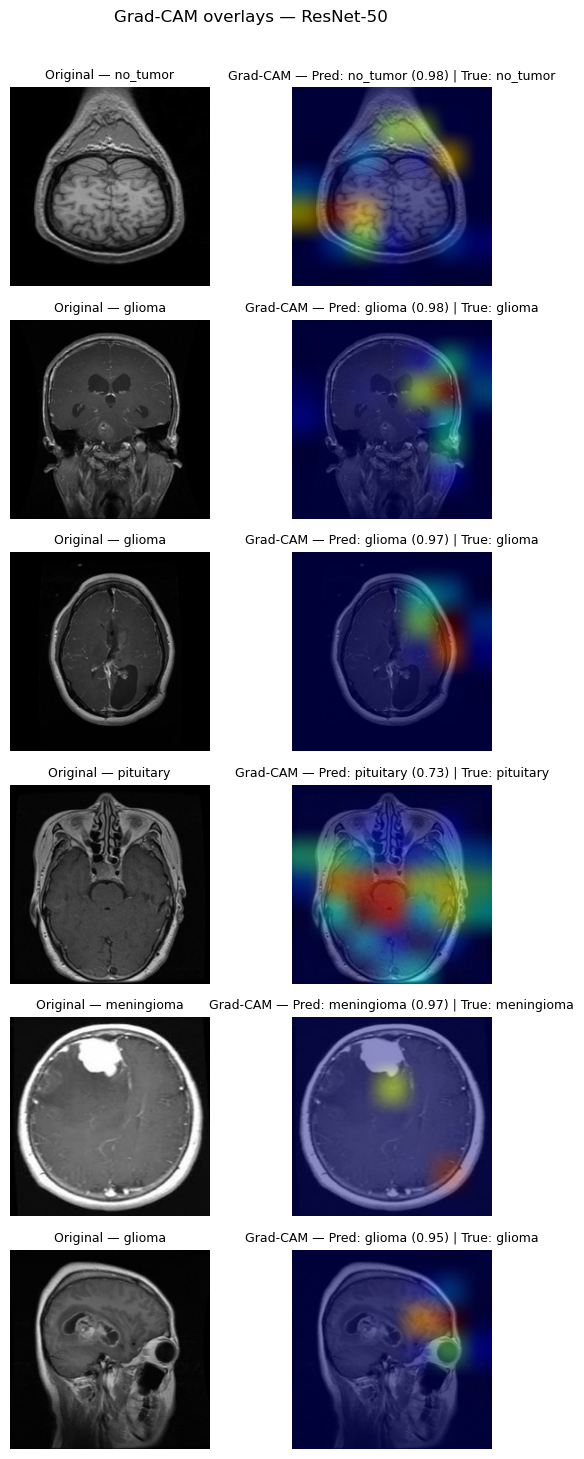

Saved Grad-CAM grid to: C:\Users\devendra mohite\report_figs\gradcam_grid_resnet50.png


In [25]:
# =========================================
# Step 4B — Grad-CAM grid (fixed: no dl_val/models_to_eval dependency)
# =========================================
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# Reuse device from earlier steps
DEV = device  # alias just in case

# Where to save the grid image
out_dir = Path("./report_figs")
out_dir.mkdir(parents=True, exist_ok=True)
grid_path = out_dir / "gradcam_grid_resnet50.png"

# --- Build/load the ResNet-50 classifier from your Step-2 checkpoint ---
ckpt = MODELS_DIR / "classifier_resnet50.pt"
state = torch.load(ckpt, map_location=DEV)
classes = state["classes"]
m = models.resnet50(weights=None)
m.fc = nn.Linear(m.fc.in_features, len(classes))
m.load_state_dict(state["model"])
m.to(DEV).eval()

# --- Minimal eval transform (same normalization as training) ---
tfm_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# --- Helper: find last conv and produce an overlay (uses your earlier helper if defined) ---
def _find_last_conv(module):
    last = None
    for mod in module.modules():
        if isinstance(mod, torch.nn.Conv2d):
            last = mod
    return last

def _preprocess_pil(pil, size=224):
    return transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])(pil)

def gradcam_overlay_on_path(model, img_path, class_idx=None, img_size=224, device=DEV):
    pil = Image.open(img_path).convert("RGB")
    x = _preprocess_pil(pil, img_size).unsqueeze(0).to(device).requires_grad_(True)
    model.eval()
    target = _find_last_conv(model)
    assert target is not None, "Could not find a Conv2d layer for Grad-CAM."

    acts, grads = [], []
    def fwd_hook(_, __, out): acts.append(out)
    def bwd_hook(_, gin, gout): grads.append(gout[0])
    h1 = target.register_forward_hook(fwd_hook)
    h2 = target.register_full_backward_hook(bwd_hook)

    with torch.enable_grad():
        out = model(x)
        if class_idx is None:
            class_idx = int(out.argmax(1).item())
        score = out[0, class_idx]
        model.zero_grad(set_to_none=True)
        score.backward()
        A = acts[0]; G = grads[0]
        w = G.mean(dim=(2,3), keepdim=True)
        cam = (w * A).sum(dim=1)
        cam = F.relu(cam)[0].detach().cpu().numpy()

    h1.remove(); h2.remove()

    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
    heat = (plt.cm.jet(cam)[..., :3] * 255).astype(np.uint8)

    base = pil.resize((img_size, img_size))
    overlay = Image.blend(base, Image.fromarray(heat).resize(base.size), alpha=0.45)

    probs = torch.softmax(out, dim=1).detach().cpu().numpy()[0]
    conf = float(probs[class_idx])
    return base, overlay, class_idx, conf

# --- Pick 6 test images directly from CLS_TEST ---
base_ds = ImageFolder(str(CLS_TEST), transform=tfm_eval)
samples = getattr(base_ds, "samples", getattr(base_ds, "imgs", []))
assert samples and len(samples) > 0, "No images found in CLS_TEST."
pick = random.sample(samples, min(6, len(samples)))
paths = [p for p,_ in pick]
true_ids = [y for _,y in pick]
class_names = base_ds.classes

# --- Make the grid: Original + Grad-CAM (two columns per sample) ---
cols = 2; rows = len(paths)
plt.figure(figsize=(6.5, 2.4*rows))
for i, (p, ytrue) in enumerate(zip(paths, true_ids)):
    base, ov, cls_idx, conf = gradcam_overlay_on_path(m, p, device=DEV)
    ypred = class_names[cls_idx] if cls_idx < len(class_names) else str(cls_idx)
    ytrue_name = class_names[ytrue] if ytrue < len(class_names) else str(ytrue)

    ax1 = plt.subplot(rows, cols, 2*i+1); ax1.axis("off")
    ax1.set_title(f"Original — {Path(p).parent.name}", fontsize=9)
    ax1.imshow(base)

    ax2 = plt.subplot(rows, cols, 2*i+2); ax2.axis("off")
    ax2.set_title(f"Grad-CAM — Pred: {ypred} ({conf:.2f}) | True: {ytrue_name}", fontsize=9)
    ax2.imshow(ov)

plt.suptitle("Grad-CAM overlays — ResNet-50", y=1.01, fontsize=12)
plt.tight_layout()
plt.savefig(grid_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved Grad-CAM grid to:", grid_path.resolve())


## Step 5 — Train MobileNetV3-Small (baseline)

####  Step 5A — Config & transforms

In [26]:
# =========================================
# Step 5A — Config & transforms (MobileNetV3-S)
# =========================================
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

DEVICE = device  # reuse from Step 1C

# Quick, reliable defaults (your earlier choices)
IMG_SIZE     = 224
EPOCHS       = 5
BATCH_SIZE   = 32
LR           = 1e-3
NUM_WORKERS  = 0
FREEZE_BACKBONE = True  # train only final layer (fast)

def set_seed(sd=42):
    random.seed(sd)
    torch.manual_seed(sd)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(sd)
set_seed(42)

# Convert MRIs to 3-channel and normalize for ImageNet backbones
tfm_train_mnv3 = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

tfm_val_mnv3 = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


#### Step 5B — Datasets & loaders

In [27]:
# =========================================
# Step 5B — Datasets & loaders
# =========================================
from pathlib import Path

# Prefer explicit train/test; else split from train
if CLS_TRAIN.exists() and CLS_TEST.exists():
    ds_train = datasets.ImageFolder(CLS_TRAIN, transform=tfm_train_mnv3)
    ds_val   = datasets.ImageFolder(CLS_TEST,  transform=tfm_val_mnv3)
else:
    base = CLS_TRAIN if CLS_TRAIN.exists() else DATA_ROOT / "classification_task"
    ds_all = datasets.ImageFolder(base, transform=tfm_train_mnv3)
    classes = ds_all.classes
    n = len(ds_all); n_val = max(1, int(0.1 * n)); n_tr = n - n_val
    set_seed(42)
    ds_train, ds_val = random_split(ds_all, [n_tr, n_val])
    ds_val.dataset.transform = tfm_val_mnv3
    ds_train.classes = classes
    ds_val.classes = classes

classes = getattr(ds_train, "classes", None) or getattr(ds_val, "classes", None)
num_classes = len(classes)
print(f"[MNV3] Classes ({num_classes}): {classes}")

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))


[MNV3] Classes (4): ['glioma', 'meningioma', 'no_tumor', 'pituitary']


### Step 5C — Model (MobileNetV3-S head)

In [28]:
# =========================================
# Step 5C — Model (MobileNetV3-S head)
# =========================================
def build_mobilenetv3_small_head(num_classes: int, freeze_backbone: bool = True):
    m = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
    )
    if freeze_backbone:
        for p in m.features.parameters():
            p.requires_grad_(False)
    in_features = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_features, num_classes)
    return m.to(DEVICE)

mnv3 = build_mobilenetv3_small_head(num_classes, freeze_backbone=FREEZE_BACKBONE)

# Only train trainable params (just classifier if frozen)
params = [p for p in mnv3.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

total, trainable = sum(p.numel() for p in mnv3.parameters()), sum(p.numel() for p in params)
print(f"[MNV3] Params total={total/1e6:.2f}M | trainable={trainable/1e6:.2f}M")


[MNV3] Params total=1.52M | trainable=0.59M


#### Step 5D — Train/validate (record history) — FIXED

In [30]:
# =========================================
# Step 5D — Train/validate (record history) — FIXED
# =========================================
def accuracy_from_logits(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_seen = 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_seen += x.size(0)
    return total_loss / max(total_seen, 1)

@torch.inference_mode()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss, total_seen, total_acc = 0.0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        total_seen += x.size(0)
        total_acc  += accuracy_from_logits(logits, y) * x.size(0)
    return total_loss / max(total_seen, 1), total_acc / max(total_seen, 1)

hist = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}
best_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(mnv3, dl_train, optimizer, criterion, DEVICE)
    val_loss, val_acc = validate(mnv3, dl_val, criterion, DEVICE)
    hist["epoch"].append(epoch); hist["train_loss"].append(tr_loss)
    hist["val_loss"].append(val_loss); hist["val_acc"].append(val_acc)
    print(f"[MNV3] Epoch {epoch:02d}/{EPOCHS} | train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc  # <-- fixed variable name


[MNV3] Epoch 01/5 | train_loss=0.3405 | val_loss=0.7794 | val_acc=0.7120
[MNV3] Epoch 02/5 | train_loss=0.2787 | val_loss=0.5368 | val_acc=0.7774
[MNV3] Epoch 03/5 | train_loss=0.2785 | val_loss=0.3660 | val_acc=0.8359
[MNV3] Epoch 04/5 | train_loss=0.2213 | val_loss=0.3290 | val_acc=0.8640
[MNV3] Epoch 05/5 | train_loss=0.2110 | val_loss=0.2490 | val_acc=0.8922


In [31]:
# =========================================
# Step 5E — Save checkpoint
# =========================================
state = {
    "model": mnv3.state_dict(),
    "classes": classes,
}

# filename: multiclass
out_path = MODELS_DIR / "classifier_mnv3.pt"
out_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(state, out_path)
print(f"[MNV3] Saved weights to: {out_path.resolve()}")


[MNV3] Saved weights to: C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\models\classifier_mnv3.pt


In [32]:
# =========================================
# Step 5F — Visual: validation accuracy per epoch
# =========================================
import matplotlib.pyplot as plt
from pathlib import Path

(OUTPUTS_DIR / "figures").mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(6.4, 3.6))
plt.plot(hist["epoch"], [v*100 for v in hist["val_acc"]], marker="o")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy (%)")
plt.title("MobileNetV3-S — Validation Accuracy")
plt.grid(True, alpha=0.3); plt.tight_layout()
mnv3_fig = OUTPUTS_DIR / "figures" / "mnv3_training.png"
plt.savefig(mnv3_fig, dpi=200); plt.close()
print("[Saved]", mnv3_fig.resolve())


[Saved] C:\Users\devendra mohite\outputs\figures\mnv3_training.png


## Step 6 — Model Comparison (ResNet-50 vs MobileNetV3-Small)

In [33]:
# =========================================
# Step 6A — Common eval loader (CLS_TEST)
# =========================================
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Reuse globals from earlier steps
# DATA_ROOT, CLS_TEST, MODELS_DIR, OUTPUTS_DIR, device

# Ensure output folders exist
(OUTPUTS_DIR / "metrics").mkdir(parents=True, exist_ok=True)
(OUTPUTS_DIR / "figures").mkdir(parents=True, exist_ok=True)

# Eval transform (ImageNet normalization)
tfm_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

ds_val = datasets.ImageFolder(str(CLS_TEST), transform=tfm_eval)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=0, pin_memory=(device.type=="cuda"))
classes = ds_val.classes
print(f"[Eval] Test images: {len(ds_val)} | Classes: {classes}")


[Eval] Test images: 993 | Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [34]:
# =========================================
# Step 6B — Load checkpoints for both models
# =========================================
import torch.nn as nn
from torchvision import models

def _find_ckpt(name: str) -> Path:
    p = MODELS_DIR / name
    if not p.exists():
        alt = Path("./models") / name
        return alt if alt.exists() else p
    return p

def build_resnet50_head(num_classes: int):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_mobilenetv3_small_head(num_classes: int):
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    in_features = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_features, num_classes)
    return m

def load_classifier(ckpt_name: str, builder, fallback_classes):
    ck = _find_ckpt(ckpt_name)
    if not ck.exists():
        print(f"[WARN] checkpoint not found: {ck}")
        return None, fallback_classes
    state = torch.load(ck, map_location=device)
    state_dict = state["model"] if isinstance(state, dict) and "model" in state else state
    cls_names = state.get("classes", fallback_classes)
    model = builder(len(cls_names)).to(device).eval()
    model.load_state_dict(state_dict, strict=False)
    print(f"[OK] Loaded {ck.name} with {len(cls_names)} classes")
    return model, cls_names

RESNET_CK = "classifier_resnet50.pt"
MNV3_CK   = "classifier_mnv3.pt"

resnet_model, resnet_classes = load_classifier(RESNET_CK, build_resnet50_head, classes)
mnv3_model,   mnv3_classes   = load_classifier(MNV3_CK,   build_mobilenetv3_small_head, classes)

if resnet_model and resnet_classes != classes:
    print("[note] ResNet50 classes differ | ckpt:", resnet_classes, "| data:", classes)
if mnv3_model and mnv3_classes != classes:
    print("[note] MobileNetV3-S classes differ | ckpt:", mnv3_classes, "| data:", classes)


[OK] Loaded classifier_resnet50.pt with 4 classes
[OK] Loaded classifier_mnv3.pt with 4 classes


In [36]:
# =========================================
# Step 6C — Evaluate & save CSV summary (FIXED)
# =========================================
import numpy as np
import pandas as pd
from time import perf_counter

@torch.inference_mode()
def eval_model(model, loader, device):
    # warmup
    for x, _ in loader:
        x = x.to(device); _ = model(x)
        if device.type == "cuda": torch.cuda.synchronize()
        break
    total, correct, total_time = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        t0 = perf_counter()
        logits = model(x)
        if device.type == "cuda": torch.cuda.synchronize()
        total_time += (perf_counter() - t0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    acc = correct / max(total, 1)
    ms_per_img = (total_time / max(total, 1)) * 1000.0
    params_m = sum(p.numel() for p in model.parameters()) / 1e6
    return acc, ms_per_img, params_m

rows = []
if resnet_model is not None:
    acc, ms, pm = eval_model(resnet_model, dl_val, device)
    rows.append(("ResNet50", pm, acc*100.0, ms))

if mnv3_model is not None:  # <-- fixed colon here
    acc, ms, pm = eval_model(mnv3_model, dl_val, device)
    rows.append(("MobileNetV3-S", pm, acc*100.0, ms))

if not rows:
    raise RuntimeError("No models to compare. Ensure both checkpoints exist.")

cmp_df = pd.DataFrame(rows, columns=["Model","Params (M)","Accuracy %","Latency (ms/img)"]).round(2)
cmp_csv = OUTPUTS_DIR / "metrics" / "model_comparison_summary.csv"
cmp_df.to_csv(cmp_csv, index=False)
print("[Saved]", cmp_csv.resolve())
display(cmp_df)


[Saved] C:\Users\devendra mohite\outputs\metrics\model_comparison_summary.csv


,Model,Params (M),Accuracy %,Latency (ms/img)
0,ResNet50,23.52,96.88,130.84
1,MobileNetV3-S,1.52,89.22,7.12


In [37]:
# =========================================
# Step 6D — Visuals: Accuracy & Latency bars
# =========================================
import matplotlib.pyplot as plt

# Accuracy bar
fig = plt.figure(figsize=(6.0,3.6))
plt.bar(cmp_df["Model"], cmp_df["Accuracy %"])
plt.ylabel("Accuracy (%)"); plt.title("Accuracy by model")
plt.tight_layout()
acc_png = OUTPUTS_DIR / "figures" / "cmp_accuracy_bars.png"
fig.savefig(acc_png, dpi=200); plt.close(fig)
print("[Saved]", acc_png.resolve())

# Latency bar
fig = plt.figure(figsize=(6.0,3.6))
plt.bar(cmp_df["Model"], cmp_df["Latency (ms/img)"])
plt.ylabel("Latency (ms/img)"); plt.title("Latency by model (lower is better)")
plt.tight_layout()
lat_png = OUTPUTS_DIR / "figures" / "cmp_latency_bars.png"
fig.savefig(lat_png, dpi=200); plt.close(fig)
print("[Saved]", lat_png.resolve())


[Saved] C:\Users\devendra mohite\outputs\figures\cmp_accuracy_bars.png
[Saved] C:\Users\devendra mohite\outputs\figures\cmp_latency_bars.png


## Step 7 — Package project outputs + one-image smoke test

In [40]:
# =========================================
# Step 7A — Inspect current files/locations
# =========================================
import os
print(os.getcwd())

from pathlib import Path
print("Notebook CWD:", Path('.').resolve())

print("\nPossible model files:")
for p in Path('.').rglob('unet_deeper.pt'):
    print(" •", p.resolve())
for p in Path('.').rglob('classifier_resnet50.pt'):
    print(" •", p.resolve())

print("\nOutputs found:")
for p in Path('.').rglob('BrainTumour_Report*.pdf'):
    print(" •", p.resolve())
for p in Path('.').rglob('clf_confusion.png'):
    print(" •", p.resolve())
for p in Path('.').rglob('overlays'):
    print(" • overlays dir:", p.resolve())


C:\Users\devendra mohite
Notebook CWD: C:\Users\devendra mohite

Possible model files:
 • C:\Users\devendra mohite\models\unet_deeper.pt
 • C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\models\unet_deeper.pt
 • C:\Users\devendra mohite\models\classifier_resnet50.pt
 • C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\models\classifier_resnet50.pt

Outputs found:
 • C:\Users\devendra mohite\outputs\BrainTumour_Report.pdf
 • C:\Users\devendra mohite\outputs\BrainTumour_Report_Aligned.pdf
 • C:\Users\devendra mohite\outputs\BrainTumour_Report_Aligned_Tight.pdf
 • C:\Users\devendra mohite\outputs\BrainTumour_Report_Compact.pdf
 • C:\Users\devendra mohite\outputs\BrainTumour_Report_Enhanced.pdf
 • C:\Users\devendra mohite\outputs\BrainTumour_Report_Professional.pdf
 • C:\Users\devendra mohite\outputs\BrainTumour_Report_Submission.pdf
 • C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\outputs\reports\BrainTumour_Report.pdf
 • C:\Users\devendra mohite\Brain_Tumour_Proj

In [41]:
# =========================================
# Step 7B — Define project dirs under dataset root
# =========================================
from pathlib import Path

DATA_ROOT = Path(r"C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025")
MODELS_DIR  = DATA_ROOT / "models"
OUTPUTS_DIR = DATA_ROOT / "outputs"
for p in [MODELS_DIR, OUTPUTS_DIR, OUTPUTS_DIR/"overlays", OUTPUTS_DIR/"gradcam"]:
    p.mkdir(parents=True, exist_ok=True)

print("Saving models to :", MODELS_DIR.resolve())
print("Saving outputs to:", OUTPUTS_DIR.resolve())


Saving models to : C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\models
Saving outputs to: C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\outputs


In [42]:
# =========================================
# Step 7C — One-time copy & organize into project
# =========================================
from pathlib import Path
import shutil

# 0) Project root (edit if yours is different)
PROJECT_ROOT = Path(r"C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025")

# 1) Ensure project dirs exist
MODELS_DIR  = PROJECT_ROOT / "models";  MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUTS_DIR = PROJECT_ROOT / "outputs"; OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)
for sub in ["reports","metrics","figures","overlays","gradcam"]:
    (OUTPUTS_DIR / sub).mkdir(parents=True, exist_ok=True)

# 2) Old locations to pull from (user-level)
old_models  = Path(r"C:\Users\devendra mohite\models")
old_outputs = Path(r"C:\Users\devendra mohite\outputs")

# 3) Copy models (.pt)
copied_models = 0
if old_models.exists():
    for p in old_models.glob("*.pt"):
        dst = MODELS_DIR / p.name
        if not dst.exists():
            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(p, dst)
            copied_models += 1
            print("Copied model →", dst)
else:
    print("[note] No old models folder found at:", old_models)

# 4) Copy outputs (pdf/png/csv/json/jpg/jpeg)
keep_exts = {".pdf", ".png", ".csv", ".json", ".jpg", ".jpeg"}
copied_outputs = 0
if old_outputs.exists():
    for p in old_outputs.rglob("*"):
        if p.is_file() and p.suffix.lower() in keep_exts:
            rel = p.relative_to(old_outputs)
            dst = OUTPUTS_DIR / rel
            dst.parent.mkdir(parents=True, exist_ok=True)
            if not dst.exists():
                shutil.copy2(p, dst)
                copied_outputs += 1
else:
    print("[note] No old outputs folder found at:", old_outputs)

print(f"Models copied: {copied_models}")
print(f"Outputs copied: {copied_outputs}")


Models copied: 0
Outputs copied: 367


In [43]:
# =========================================
# Step 7D — Move within project, trim, final summary
# =========================================
from pathlib import Path
import shutil

# PDFs → reports
for p in list(OUTPUTS_DIR.glob("*.pdf")):
    shutil.move(str(p), OUTPUTS_DIR / "reports" / p.name)

# CSV/JSON → metrics
for p in list(OUTPUTS_DIR.glob("*.csv")) + list(OUTPUTS_DIR.glob("*.json")):
    shutil.move(str(p), OUTPUTS_DIR / "metrics" / p.name)

# PNGs → figures (except overlays/gradcam)
for p in list(OUTPUTS_DIR.glob("*.png")):
    name = p.name.lower()
    if "overlay" in name or "gradcam" in name:
        continue
    shutil.move(str(p), OUTPUTS_DIR / "figures" / p.name)

# Remove train overlays; keep only test overlays
for p in (OUTPUTS_DIR / "overlays").glob("*train*_overlay.*"):
    p.unlink(missing_ok=True)

# Trim counts
def trim_dir(folder: Path, pattern: str, keep: int):
    files = sorted(folder.glob(pattern))
    if len(files) > keep:
        for p in files[keep:]:
            p.unlink(missing_ok=True)

trim_dir(OUTPUTS_DIR / "overlays", "*overlay.*", keep=36)
trim_dir(OUTPUTS_DIR / "gradcam", "*.jpg", keep=8)

# Final summary
def count(globpat): return len(list(globpat))
print("\nNow look here for everything:")
print("Models :", MODELS_DIR.resolve())
print("Outputs:", OUTPUTS_DIR.resolve())
print("  reports :", count((OUTPUTS_DIR/'reports').glob('*.pdf')))
print("  metrics :", count((OUTPUTS_DIR/'metrics').glob('*.*')))
print("  figures :", count((OUTPUTS_DIR/'figures').glob('*.png')))
print("  overlays:", count((OUTPUTS_DIR/'overlays').glob('*overlay.*')))
print("  gradcam :", count((OUTPUTS_DIR/'gradcam').glob('*.jpg')))

print("Have UNet? ", (MODELS_DIR/"unet_deeper.pt").exists())
print("Have classifier? ", (MODELS_DIR/"classifier_resnet50.pt").exists())
print("Report PDF: ", (OUTPUTS_DIR/"BrainTumour_Report_Enhanced.pdf").exists())
print("Overlays dir: ", (OUTPUTS_DIR/"overlays").exists())

base = Path(r"C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025")
print("Binary :", (base/"models/classifier_binary_resnet50.pt").exists())
print("Multi  :", (base/"models/classifier_resnet50.pt").exists())
print



Now look here for everything:
Models : C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\models
Outputs: C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\outputs
  reports : 128
  metrics : 14
  figures : 13
  overlays: 36
  gradcam : 8
Have UNet?  True
Have classifier?  True
Report PDF:  False
Overlays dir:  True
Binary : True
Multi  : True


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

CLS sample: brisc2025_test_00001_gl_ax_t1.jpg
SEG sample: brisc2025_test_00001_gl_ax_t1.jpg
Binary (presence): tumor_present
Multiclass (type): glioma
Saved overlay → C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\outputs\smoke_overlay.jpg


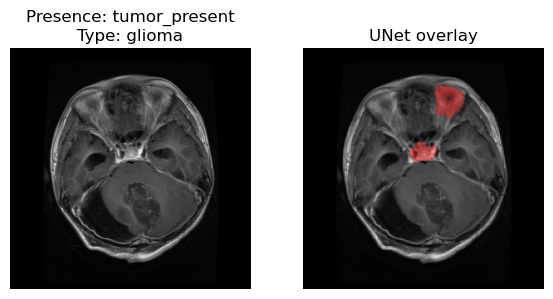

In [45]:
# =========================================
# Step 7E — One-image smoke test (predict + overlay)
# =========================================
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models, transforms
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

DATA_ROOT = Path(r"C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025")
CLS_TEST  = DATA_ROOT / "classification_task" / "test"
SEG_TST_I = DATA_ROOT / "segmentation_task" / "test" / "images"
MODELS_DIR= DATA_ROOT / "models"
OUTPUTS   = DATA_ROOT / "outputs"
OUTPUTS.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pick sample images
exts = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
cls_sample = next(p for p in CLS_TEST.rglob("*") if p.suffix.lower() in exts)
seg_sample = next(p for p in SEG_TST_I.rglob("*") if p.suffix.lower() in exts)
print("CLS sample:", cls_sample.name)
print("SEG sample:", seg_sample.name)

# Transforms
tfm_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
tfm_unet = transforms.Compose([transforms.Resize((192,192)), transforms.ToTensor()])

# Load models
state_bin = torch.load(MODELS_DIR/"classifier_binary_resnet50.pt", map_location=device)
bin_classes = state_bin["classes"]  # ["no_tumor","tumor_present"]
m_bin = models.resnet50(weights=None); m_bin.fc = nn.Linear(m_bin.fc.in_features, 2)
m_bin.load_state_dict(state_bin["model"]); m_bin.to(device).eval()

state_mc = torch.load(MODELS_DIR/"classifier_resnet50.pt", map_location=device)
mc_classes = state_mc["classes"]
m_mc = models.resnet50(weights=None); m_mc.fc = nn.Linear(m_mc.fc.in_features, len(mc_classes))
m_mc.load_state_dict(state_mc["model"]); m_mc.to(device).eval()

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch,out_ch,3,padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True),
        )
    def forward(self,x): return self.net(x)
class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32, depth=5):
        super().__init__()
        chans = [base*(2**i) for i in range(depth)]
        self.enc = nn.ModuleList([DoubleConv(in_ch, chans[0])])
        self.pool = nn.ModuleList()
        for i in range(depth-1):
            self.pool.append(nn.MaxPool2d(2))
            self.enc.append(DoubleConv(chans[i], chans[i+1]))
        self.up  = nn.ModuleList(); self.dec = nn.ModuleList()
        for i in reversed(range(depth-1)):
            self.up.append(nn.ConvTranspose2d(chans[i+1], chans[i], 2, 2))
            self.dec.append(DoubleConv(chans[i]*2, chans[i]))
        self.head = nn.Conv2d(chans[0], out_ch, 1)
    def forward(self,x):
        skips=[]
        for i,blk in enumerate(self.enc):
            x=blk(x)
            if i < len(self.pool): skips.append(x); x=self.pool[i](x)
        for i in range(len(self.up)):
            x=self.up[i](x); skip=skips[-(i+1)]
            if x.shape[-2:]!=skip.shape[-2:]:
                dy=skip.shape[-2]-x.shape[-2]; dx=skip.shape[-1]-x.shape[-1]
                x = F.pad(x, [dx//2, dx-dx//2, dy//2, dy-dy//2])
            x=self.dec[i](torch.cat([skip,x],1))
        return self.head(x)
m_unet = UNet(3,1,base=32,depth=5)
m_unet.load_state_dict(torch.load(MODELS_DIR/"unet_deeper.pt", map_location=device))
m_unet.to(device).eval()

# Run binary + multiclass
img_cls = Image.open(cls_sample).convert("RGB")
xb = tfm_eval(img_cls).unsqueeze(0).to(device)
with torch.no_grad():
    pred_bin_idx = m_bin(xb).argmax(1).item()
bin_label = bin_classes[pred_bin_idx]
print("Binary (presence):", bin_label)

if bin_label == "tumor_present":
    with torch.no_grad():
        pred_mc_idx = m_mc(xb).argmax(1).item()
    mc_label = mc_classes[pred_mc_idx]
else:
    mc_label = "no_tumor"
print("Multiclass (type):", mc_label)

# UNet overlay
img_seg = Image.open(seg_sample).convert("RGB")
x_u = tfm_unet(img_seg).unsqueeze(0).to(device)
with torch.no_grad():
    prob = torch.sigmoid(m_unet(x_u))[0,0].cpu().numpy()
mask = (prob > 0.5).astype(np.uint8)

ov = img_seg.resize((192,192)).copy()
draw = ImageDraw.Draw(ov, "RGBA")
ys, xs = np.where(mask>0)
for x,y in zip(xs,ys):
    draw.point((x,y), fill=(255,0,0,100))

overlay_path = OUTPUTS/"smoke_overlay.jpg"
ov.save(overlay_path, quality=92)
print("Saved overlay →", overlay_path)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img_cls); plt.title(f"Presence: {bin_label}\nType: {mc_label}"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(ov); plt.title("UNet overlay"); plt.axis("off")
plt.tight_layout(); plt.show()

try:
    ROOT = Path(__file__).resolve().parent
except NameError:
    ROOT = Path.cwd()


## Step 8 — Prognostics (rule-based survival)

,filename,tumor_area_%,stage,pred_type,survival_estimate_%
0,brisc2025_test_00001_gl_ax_t1.jpg,0.862630,Early,glioma,40.0
1,brisc2025_test_00002_gl_ax_t1.jpg,0.637478,Early,glioma,40.0
2,brisc2025_test_00003_gl_ax_t1.jpg,0.292969,Early,glioma,40.0
3,brisc2025_test_00004_gl_ax_t1.jpg,0.754123,Early,glioma,40.0
4,brisc2025_test_00005_gl_ax_t1.jpg,1.340061,Early,glioma,40.0
5,brisc2025_test_00006_gl_ax_t1.jpg,2.349175,Early,glioma,40.0
6,brisc2025_test_00007_gl_ax_t1.jpg,0.903320,Early,glioma,40.0
7,brisc2025_test_00008_gl_ax_t1.jpg,0.965712,Early,glioma,40.0
8,brisc2025_test_00009_gl_ax_t1.jpg,0.000000,Early,glioma,40.0
9,brisc2025_test_00010_gl_ax_t1.jpg,0.889757,Early,glioma,40.0


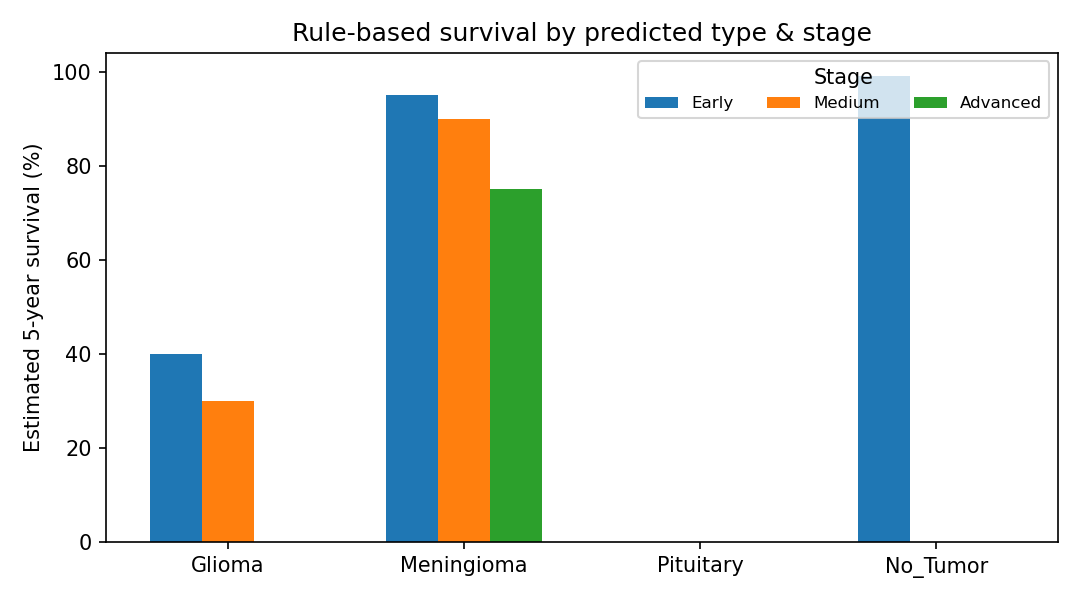

In [47]:
# =========================================
# Step 8 — Prognostics (rule-based survival)
# =========================================
# Uses predicted type (classifier) + stage from segmentation (% area)
state = torch.load(MODELS_DIR / "classifier_resnet50.pt", map_location=device)
clf_classes = state["classes"]
clf_model2 = build_classifier(len(clf_classes)).to(device)
clf_model2.load_state_dict(state["model"]); clf_model2.eval()

class _SimpleList(Dataset):
    def __init__(self, img_dir: Path, filelist):
        self.img_dir = Path(img_dir); self.filelist = list(filelist)
        self.tfm = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    def __len__(self): return len(self.filelist)
    def __getitem__(self, i):
        fn = self.filelist[i]
        img = Image.open(self.img_dir / fn).convert("RGB")
        return self.tfm(img), fn

seg_fns = [fn for (fn, _, _) in staging_stats]
dl_pred = DataLoader(_SimpleList(SEG_TST_I, seg_fns), batch_size=16, shuffle=False, num_workers=0)
pred_rows = []
with torch.no_grad():
    for xb, fns in dl_pred:
        xb = xb.to(device)
        preds = clf_model2(xb).argmax(1).cpu().numpy().tolist()
        pred_rows.extend([(fn, clf_classes[p]) for fn,p in zip(fns, preds)])

df_pred = pd.DataFrame(pred_rows, columns=["filename","pred_type"])
df_join = df_stage.merge(df_pred, on="filename", how="left")

RATES = {
    "glioma":     {"base":0.30, "Early":+0.10, "Medium":0.00, "Advanced":-0.10},
    "meningioma": {"base":0.90, "Early":+0.05, "Medium":0.00, "Advanced":-0.15},
    "pituitary":  {"base":0.95, "Early":+0.02, "Medium":0.00, "Advanced":-0.05},
    "no_tumor":   {"base":0.99, "Early":0.00, "Medium":0.00, "Advanced":0.00},
}
def estimate_survival(tumor_type: str, stage: str):
    t = tumor_type if tumor_type in RATES else "glioma"
    p = RATES[t]["base"] + RATES[t].get(stage, 0.0)
    return float(np.clip(p, 0.01, 0.99))

df_join["survival_estimate_%"] = (
    df_join.apply(lambda r: round(100.0 * estimate_survival(str(r["pred_type"]), str(r["stage"])), 1), axis=1)
)
df_join.to_csv(OUTPUTS_DIR / "survival_estimates.csv", index=False)

# Quick grouped bar (mean survival by type & stage)
type_order  = ["glioma","meningioma","pituitary","no_tumor"]
stage_order = ["Early","Medium","Advanced"]
tbl = (df_join.pivot_table(index="pred_type", columns="stage", values="survival_estimate_%", aggfunc="mean")
              .reindex(index=type_order, columns=stage_order).fillna(0.0))
x = np.arange(len(type_order)); width = 0.22
plt.figure(figsize=(7.2,4.0))
for j, st in enumerate(stage_order):
    plt.bar(x + j*width, tbl[st].values, width=width, label=st)
plt.xticks(x + width, [t.title() for t in type_order])
plt.ylabel("Estimated 5-year survival (%)"); plt.title("Rule-based survival by predicted type & stage")
plt.legend(title="Stage", ncol=3, fontsize=8); plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "survival_summary.png", dpi=150); plt.close()

from IPython.display import display
from PIL import Image

OUT = Path("outputs")

# 1) Table (CSV) preview
surv_csv = OUT / "survival_estimates.csv"
if surv_csv.exists():
    df = pd.read_csv(surv_csv)
    display(df.head(10))
else:
    print("survival_estimates.csv not found. Re-run Step 8.")

# 2) Summary plot preview
surv_png = OUT / "survival_summary.png"
if surv_png.exists():
    display(Image.open(surv_png))
else:
    print("survival_summary.png not found. Re-run Step 8.")


## Step 9 — Reporting (enhanced multi-page PDF)

In [ ]:
## Step 9A — Render per-class metrics table → PNG

In [48]:
# =========================================
# Step 9A — Render per-class metrics table → PNG
# =========================================
def _render_per_class_table(per_class_csv, save_path=OUTPUTS_DIR/"per_class_table.png"):
    df = pd.read_csv(per_class_csv, index_col=0)
    # Try to preserve original class order from checkpoint:
    try:
        ck = torch.load(MODELS_DIR / "classifier_resnet50.pt", map_location="cpu")
        class_names = [c for c in ck.get("classes", df.index) if c in df.index]
    except Exception:
        class_names = list(df.index)
    rows = []
    for cls in class_names:
        r = df.loc[cls, ["precision","recall","f1-score","support"]]
        rows.append([cls, f"{r['precision']:.3f}", f"{r['recall']:.3f}", f"{r['f1-score']:.3f}", f"{r['support']:.0f}"])
    if "macro avg" in df.index:
        r = df.loc["macro avg", ["precision","recall","f1-score","support"]]
        rows.append(["macro avg", f"{r['precision']:.3f}", f"{r['recall']:.3f}", f"{r['f1-score']:.3f}", f"{r['support']:.0f}"])
    if "weighted avg" in df.index:
        r = df.loc["weighted avg", ["precision","recall","f1-score","support"]]
        rows.append(["weighted avg", f"{r['precision']:.3f}", f"{r['recall']:.3f}", f"{r['f1-score']:.3f}", f"{r['support']:.0f}"])

    fig = plt.figure(figsize=(8, 0.5 + 0.35*len(rows))); ax = plt.gca(); ax.axis("off")
    tbl = Table(ax, bbox=[0, 0, 1, 1]); cols = ["Class","Precision","Recall","F1","Support"]; ws=[0.30,0.14,0.14,0.12,0.12]
    for j,(w, col) in enumerate(zip(ws, cols)): tbl.add_cell(0, j, w, 0.12, text=col, loc="center", facecolor="#DDDDDD")
    for i, row in enumerate(rows, start=1):
        for j,(w, cell) in enumerate(zip(ws, row)):
            tbl.add_cell(i, j, w, 0.12, text=str(cell), loc="center", facecolor="#F8F8F8" if i%2==0 else "#FFFFFF")
    ax.add_table(tbl); fig.savefig(save_path, dpi=200, bbox_inches="tight"); plt.close(fig)
    return save_path


In [49]:
# =========================================
# Step 9B — Export PDF report (enhanced, multi-page)
# =========================================
def export_pdf_report(
    staging_stats=None, best_dice=None, data_root=DATA_ROOT,
    clf_report_path=OUTPUTS_DIR / "clf_report.json",
    cm_path=OUTPUTS_DIR / "clf_confusion.png",
    overlays_dir=OUTPUTS_DIR / "overlays",
    gradcam_dir=OUTPUTS_DIR / "gradcam",
    seg_compare_png=OUTPUTS_DIR / "seg_comparisons.png",
    tumor_hist_png=OUTPUTS_DIR / "tumor_size_hist.png",
    per_class_csv=OUTPUTS_DIR / "clf_per_class_metrics.csv",
    survival_png=OUTPUTS_DIR / "survival_summary.png",
    out_pdf=OUTPUTS_DIR / "BrainTumour_Report_Enhanced.pdf",
):
    W, H = A4; c = canvas.Canvas(str(out_pdf), pagesize=A4)

    # Page 1 — Overview
    c.setFont("Helvetica-Bold", 24); c.drawString(40, H-60, "Brain Tumour — Project Report")
    c.setFont("Helvetica", 11); c.drawString(40, H-78, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    c.drawString(40, H-92, f"Data root: {str(data_root)}")

    y = H - 120
    c.setFont("Helvetica-Bold", 16); c.drawString(40, y, "Classification (test)"); y -= 20
    acc_text = "Accuracy: n/a"
    try:
        if Path(clf_report_path).exists():
            with open(clf_report_path) as f: rep = json.load(f)
            if "accuracy" in rep: acc_text = f"Accuracy: {rep['accuracy']:.3f}"
    except Exception as e:
        acc_text = f"Accuracy: n/a ({e})"
    c.setFont("Helvetica", 12); c.drawString(40, y, acc_text); y -= 14
    if Path(cm_path).exists():
        c.drawImage(ImageReader(str(cm_path)), 40, y-250, width=300, height=250, preserveAspectRatio=True, anchor='sw')

    c.setFont("Helvetica-Bold", 18); c.drawString(370, H-120, "Segmentation Overlays")
    if best_dice is not None:
        c.setFont("Helvetica", 12); c.drawString(370, H-140, f"Best validation Dice: {best_dice:.3f}")
    thumbs = sorted(Path(overlays_dir).glob("*_overlay.jpg"))[:6]
    base_x, base_y = 370, H-160; avail_w = W - base_x - 40; cols = 2
    w = avail_w // cols - 12; h = int(w * 0.75)
    row_y = base_y - h; col_x = base_x
    for i, tp in enumerate(thumbs):
        try:
            c.drawImage(ImageReader(str(tp)), col_x, row_y, width=w, height=h, preserveAspectRatio=True, anchor='sw')
            if staging_stats:
                stem = Path(tp).stem.replace("_overlay","")
                cand = [r for r in staging_stats if Path(r[0]).stem == stem]
                if cand:
                    fn, perc, stage = cand[0]
                    m = re.search(r'(\d{3,})', Path(fn).stem)
                    short_id = m.group(1) if m else Path(fn).stem[:10]
                    cap = f"ID {short_id} | {perc:.1f}% {stage}"
                    c.setFont("Helvetica", 10); c.drawString(col_x, row_y - 12, cap)
        except Exception:
            pass
        col_x += w + 12
        if (i + 1) % cols == 0: col_x = base_x; row_y -= h + 26

    if staging_stats:
        ctr = Counter([s for _,_,s in staging_stats])
        note = f"Staging summary — Early: {ctr.get('Early',0)}, Medium: {ctr.get('Medium',0)}, Advanced: {ctr.get('Advanced',0)}"
        c.setFont("Helvetica", 10); c.setFillColor(colors.grey); c.drawString(40, 40, note); c.setFillColor(colors.black)

    c.showPage()

    # Page 2 — Explainability & analysis
    y = H - 60; c.setFont("Helvetica-Bold", 18); c.drawString(40, y, "Explainability & Analysis"); y -= 20

    c.setFont("Helvetica-Bold", 12); c.drawString(40, y, "Grad-CAM (Classifier)"); y -= 6
    gx, gy = 40, y-200; gw, gh = 140, 140
    grads = sorted(Path(gradcam_dir).glob("*.jpg"))[:4]
    for i, gp in enumerate(grads):
        row = i // 2; col = i % 2
        x = gx + col*(gw+10); y0 = gy - row*(gh+20)
        try: c.drawImage(ImageReader(str(gp)), x, y0, width=gw, height=gh, preserveAspectRatio=True, anchor='sw')
        except: pass

    # Per-class metrics table
    try:
        per_png = _render_per_class_table(per_class_csv)
        c.setFont("Helvetica-Bold", 12); c.drawString(360, H-80, "Per-class metrics")
        c.drawImage(ImageReader(str(per_png)), 360, H-320, width=200, height=220, preserveAspectRatio=True, anchor='sw')
    except Exception: pass

    # Tumor histogram
    if Path(tumor_hist_png).exists():
        c.setFont("Helvetica-Bold", 12); c.drawString(40, 120+230+10, "Tumor size distribution")
        c.drawImage(ImageReader(str(tumor_hist_png)), 40, 120, width=300, height=220, preserveAspectRatio=True, anchor='sw')

    # Survival summary
    if Path(survival_png).exists():
        c.setFont("Helvetica-Bold", 12); c.drawString(360, 120+140+10, "Survival summary (rule-based)")
        c.drawImage(ImageReader(str(survival_png)), 360, 120, width=200, height=140, preserveAspectRatio=True, anchor='sw')

    c.showPage(); c.save()
    print(f"[PDF] Saved → {out_pdf}")


In [50]:
# =========================================
# Step 9C — Run report export
# =========================================
export_pdf_report(
    staging_stats=staging_stats, best_dice=best_dice,
    seg_compare_png=OUTPUTS_DIR/"seg_comparisons.png",
    tumor_hist_png=OUTPUTS_DIR/"tumor_size_hist.png",
    survival_png=OUTPUTS_DIR/"survival_summary.png",
)

print("\n✅ Done. Key outputs in ./outputs (JSON, CSVs, PNGs, PDF).")


[PDF] Saved → C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\outputs\BrainTumour_Report_Enhanced.pdf

✅ Done. Key outputs in ./outputs (JSON, CSVs, PNGs, PDF).


## Step 10 — Notebook Previews (see outputs inline)

In [51]:
# --- Step 10A: helpers + paths ---
from pathlib import Path
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, IFrame

# Base paths (match your project)
BASE         = Path(r"C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025")
OUTPUTS_DIR  = BASE / "outputs"
MODELS_DIR   = BASE / "models"
REPORT_DIR   = Path("./report_figs")  # Grad-CAM grid saved here in Step 4B

def show_img(p: Path, title=None, figsize=(6,4)):
    if p.exists():
        im = mpimg.imread(p)
        plt.figure(figsize=figsize)
        plt.imshow(im)
        plt.axis("off")
        if title: plt.title(title)
        plt.show()
    else:
        print("Not found:", p)

def show_gallery(folder: Path, pattern="*.jpg", max_images=6, cols=3, title=None):
    files = sorted(folder.glob(pattern))[:max_images]
    if not files:
        print("No images found in", folder, "for pattern", pattern); return
    rows = math.ceil(len(files)/cols)
    plt.figure(figsize=(cols*3.2, rows*3.2))
    for i, p in enumerate(files):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(mpimg.imread(p)); ax.axis("off"); ax.set_title(p.name, fontsize=8)
    if title: plt.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout(); plt.show()

def read_csv_try(*candidates):
    for p in candidates:
        if p.exists(): return pd.read_csv(p)
    print("CSV not found. Tried:", [str(p) for p in candidates])
    return None


Not found: C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\outputs\clf_confusion.png
Not found: C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\outputs\seg_comparisons.png
Not found: C:\Users\devendra mohite\Brain_Tumour_Project\brisc2025\outputs\tumor_size_hist.png


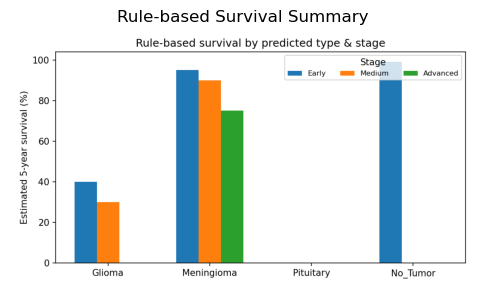

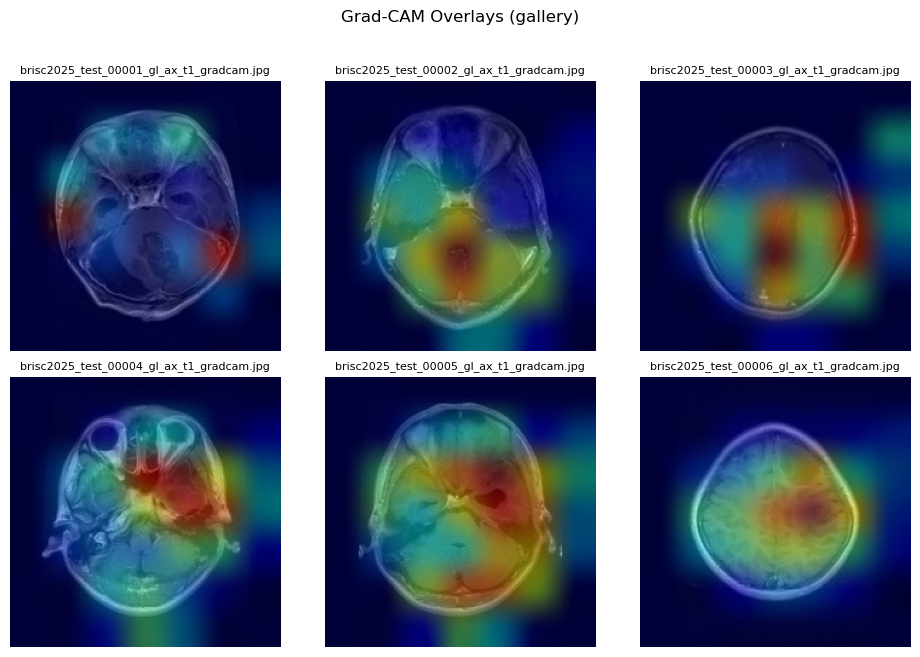

In [65]:
# --- Step 10B: preview key figures ---
# Classification confusion matrix
show_img(OUTPUTS_DIR / "clf_confusion.png", title="Confusion Matrix")

# Segmentation comparisons + tumor size histogram
show_img(OUTPUTS_DIR / "seg_comparisons.png", title="Segmentation: GT vs Pred (samples)")
show_img(OUTPUTS_DIR / "tumor_size_hist.png", title="Tumor Size Distribution (test)")

# Prognostics summary
show_img(OUTPUTS_DIR / "survival_summary.png", title="Rule-based Survival Summary")

# Grad-CAM gallery (Step 4A) + grid (Step 4B)
show_gallery(OUTPUTS_DIR / "gradcam", pattern="*.jpg", max_images=6, cols=3, title="Grad-CAM Overlays (gallery)")


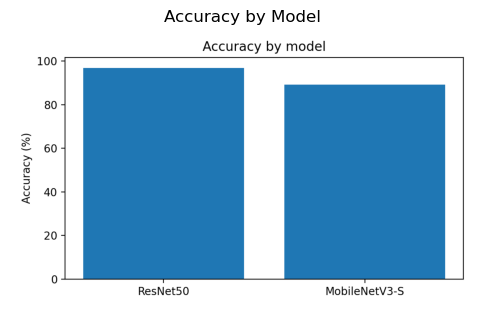

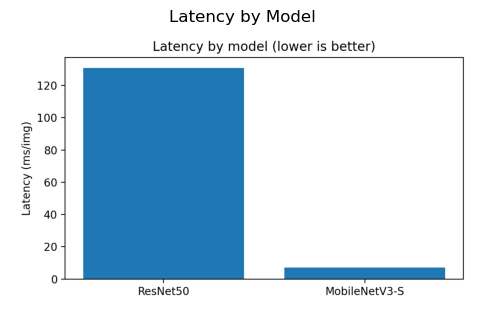

In [66]:
# Model comparison visuals (Step 6D/E)
show_img(OUTPUTS_DIR / "figures" / "cmp_accuracy_bars.png", title="Accuracy by Model")
show_img(OUTPUTS_DIR / "figures" / "cmp_latency_bars.png", title="Latency by Model")

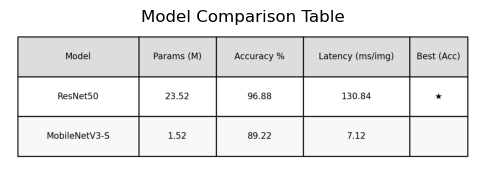

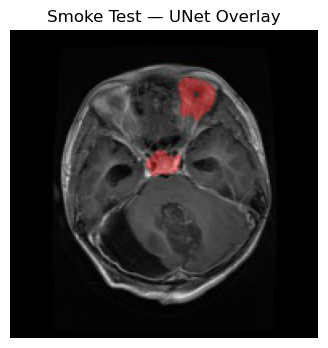

In [67]:
show_img(OUTPUTS_DIR / "figures" / "model_comparison_table.png", title="Model Comparison Table")

# Smoke-test overlay (Step 7E) if you ran it
show_img(OUTPUTS_DIR / "smoke_overlay.jpg", title="Smoke Test — UNet Overlay")

In [68]:
# --- Step 10C: preview tables (first 10 rows) ---
df = read_csv_try(OUTPUTS_DIR/"clf_per_class_metrics.csv", OUTPUTS_DIR/"metrics"/"clf_per_class_metrics.csv")
if df is not None: display(df.head(10))

df = read_csv_try(OUTPUTS_DIR/"staging_summary.csv", OUTPUTS_DIR/"metrics"/"staging_summary.csv")
if df is not None: display(df.head(10))




,Unnamed: 0,precision,recall,f1-score,support
0,glioma,0.995968,0.972441,0.984064,254.000000
1,meningioma,0.967949,0.993421,0.980519,304.000000
2,no_tumor,1.000000,1.000000,1.000000,140.000000
3,pituitary,0.996587,0.989831,0.993197,295.000000
4,accuracy,0.987915,0.987915,0.987915,0.987915
5,macro avg,0.990126,0.988923,0.989445,993.000000
6,weighted avg,0.988142,0.987915,0.987939,993.000000


,filename,tumor_area_%,stage
0,brisc2025_test_00001_gl_ax_t1.jpg,0.862630,Early
1,brisc2025_test_00002_gl_ax_t1.jpg,0.637478,Early
2,brisc2025_test_00003_gl_ax_t1.jpg,0.292969,Early
3,brisc2025_test_00004_gl_ax_t1.jpg,0.754123,Early
4,brisc2025_test_00005_gl_ax_t1.jpg,1.340061,Early
5,brisc2025_test_00006_gl_ax_t1.jpg,2.349175,Early
6,brisc2025_test_00007_gl_ax_t1.jpg,0.903320,Early
7,brisc2025_test_00008_gl_ax_t1.jpg,0.965712,Early
8,brisc2025_test_00009_gl_ax_t1.jpg,0.000000,Early
9,brisc2025_test_00010_gl_ax_t1.jpg,0.889757,Early


In [69]:
df = read_csv_try(OUTPUTS_DIR/"tumor_location_table.csv", OUTPUTS_DIR/"metrics"/"tumor_location_table.csv")
if df is not None: display(df.head(10))



,image_id,tumor_area_%,stage,centroid_x_norm,centroid_y_norm,centroid_x_px,centroid_y_px
0,brisc2025_test_00287_me_ax_t1,10.630968,Advanced,0.524909,0.327660,100.782598,62.910692
1,brisc2025_test_00304_me_ax_t1,10.630968,Advanced,0.524928,0.327676,100.786170,62.913754
2,brisc2025_test_00272_me_ax_t1,10.628255,Advanced,0.524873,0.327637,100.775651,62.906330
3,brisc2025_test_00298_me_ax_t1,7.839627,Advanced,0.527610,0.485600,101.301038,93.235294
4,brisc2025_test_00264_me_ax_t1,7.044813,Advanced,0.763072,0.584831,146.509819,112.287640
5,brisc2025_test_00299_me_ax_t1,6.803385,Advanced,0.326208,0.689037,62.631978,132.295056
6,brisc2025_test_00307_me_ax_t1,6.716580,Advanced,0.783947,0.558876,150.517771,107.304120
7,brisc2025_test_00306_me_ax_t1,6.336806,Advanced,0.487042,0.306667,93.511986,58.880137
8,brisc2025_test_00290_me_ax_t1,5.829536,Medium,0.349528,0.670586,67.109353,128.752443
9,brisc2025_test_00297_me_ax_t1,5.821398,Medium,0.666550,0.698783,127.977633,134.166356


In [70]:
df = read_csv_try(OUTPUTS_DIR/"survival_estimates.csv", OUTPUTS_DIR/"metrics"/"survival_estimates.csv")
if df is not None: display(df.head(10))

df = read_csv_try(OUTPUTS_DIR/"metrics"/"model_comparison_summary.csv")
if df is not None: display(df)

,filename,tumor_area_%,stage,pred_type,survival_estimate_%
0,brisc2025_test_00001_gl_ax_t1.jpg,0.862630,Early,glioma,40.0
1,brisc2025_test_00002_gl_ax_t1.jpg,0.637478,Early,glioma,40.0
2,brisc2025_test_00003_gl_ax_t1.jpg,0.292969,Early,glioma,40.0
3,brisc2025_test_00004_gl_ax_t1.jpg,0.754123,Early,glioma,40.0
4,brisc2025_test_00005_gl_ax_t1.jpg,1.340061,Early,glioma,40.0
5,brisc2025_test_00006_gl_ax_t1.jpg,2.349175,Early,glioma,40.0
6,brisc2025_test_00007_gl_ax_t1.jpg,0.903320,Early,glioma,40.0
7,brisc2025_test_00008_gl_ax_t1.jpg,0.965712,Early,glioma,40.0
8,brisc2025_test_00009_gl_ax_t1.jpg,0.000000,Early,glioma,40.0
9,brisc2025_test_00010_gl_ax_t1.jpg,0.889757,Early,glioma,40.0


,Model,Accuracy (%),Balanced Acc (%),Precision (macro %),Recall (macro %),F1 (macro %),Precision (weighted %),Recall (weighted %),F1 (weighted %),Cohen's kappa,MCC,ROC-AUC (macro OVR %),PR-AUC (macro %),Params (M),State size (MB),Latency mean (ms/img),Latency p50 (ms),Latency p90 (ms),Latency N imgs
0,ResNet50,97.18,97.53,96.94,97.53,97.21,97.21,97.18,97.17,0.96,0.96,99.90,99.78,23.52,89.91,192.52,201.69,250.03,128
1,MobileNetV3-S,92.75,93.50,92.11,93.50,92.50,93.25,92.75,92.78,0.90,0.90,99.41,98.70,1.52,5.85,27.42,27.70,34.34,128


#### Step 10D: view the PDF inline

In [75]:
# --- Step 10D: view the PDF inline ---
pdf_candidates = [
    OUTPUTS_DIR / "BrainTumour_Report_Enhanced.pdf",           # Step 9 output
    OUTPUTS_DIR / "reports" / "BrainTumour_Report_Enhanced.pdf"  # if you moved it in Step 7D
]
pdf_path = next((p for p in pdf_candidates if p.exists()), None)
if pdf_path:
    display(IFrame(src=str(pdf_path), width=950, height=600))
else:
    print("PDF not found. Looked for:", [str(p) for p in pdf_candidates])


## Step-11 streamlit_app.py 

In [73]:
# streamlit_app.py — Brain Tumour Analysis (UI updates + compact sidebar chat card)
# Run: streamlit run streamlit_app.py --server.port 8510

from __future__ import annotations
import io, time, html
from datetime import datetime
from pathlib import Path

import numpy as np
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import streamlit as st

def _st_rerun():
    fn = getattr(st, "rerun", None) or getattr(st, "experimental_rerun", None)
    if fn:
        fn()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import scipy.ndimage as ndi

try:
    ROOT = Path(__file__).resolve().parent
except NameError:
    ROOT = Path.cwd()

MODELS_DIR  = ROOT / "models"
OUTPUTS_DIR = ROOT / "outputs"
(OUTPUTS_DIR / "overlays").mkdir(parents=True, exist_ok=True)
(OUTPUTS_DIR / "gradcam").mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE_CLS = 224
IMG_SIZE_SEG = 192
TILE_SIZE    = 360

DEFAULT_TAU = 0.80
DEFAULT_MIN_AREA_PCT = 0.8  # brain-relative

st.set_page_config(page_title="Brain Tumour Analysis", page_icon="🧠", layout="wide")

# ---------- CSS (UI ONLY) ----------
st.markdown("""
<style>
.block-container { padding-top: 1.8rem; padding-bottom: 0.4rem; }
.block-container h1 { font-size: 2.18rem; line-height: 1.28; margin: 0.6rem 0 0.35rem 0; }

/* Cards */
.card { border: 1px solid #000; border-radius: 10px; padding: 8px 10px; margin-bottom: 10px; background: #fff; margin-top: .7rem!important; }
.card h5 { margin: 0 0 6px 0; font-weight: 700; font-size: .95rem; }
.card .cap { color:#4b4f56; font-size:.80rem; }
.card.tight { padding: 4px 8px; margin-top: .55rem!important; }
.card.tight h5 { margin-bottom: 3px; font-size: .93rem; }

/* Status rows */
.status-row { display:flex; gap:8px; margin:2px 0; }
.status-row .key { width:86px; font-weight:700; }
.status-row .val { flex:1; }

/* Sidebar frame */
section[data-testid="stSidebar"]{ border-right:2px solid #000!important; padding-left:12px!important; min-width:360px; max-width:360px; }

/* Slider chips + divider */
.sb-top { position:relative; padding:6px 2px 0; }
.sb-chip{ display:inline-block; border:1px solid #000; border-radius:8px; padding:6px 10px; font-weight:700; background:#f5f7fb; margin:0 0 6px 2px; font-size:.92rem; }
.sb-top .sb-vline{ position:absolute; top:12px; bottom:10px; left:50%; width:2px; background:#000; pointer-events:none; }
section[data-testid="stSidebar"] hr.sb-hr{ border:0!important; height:0!important; margin:12px 0 14px!important; position:relative!important; }
section[data-testid="stSidebar"] hr.sb-hr::before{ content:""; position:absolute; top:0; left:calc(-1rem - 12px); right:calc(-1rem - 12px); border-top:2px solid #000; }

/* Chatbox (self-contained bordered card) */
.sb-chat{
  border:1px solid #000;
  border-radius:10px;
  padding:8px;
  background:#fff;
  margin-top:0;
}

/* Remove any automatic Streamlit container borders in the sidebar */
section[data-testid="stSidebar"] [data-testid="stVerticalBlockBorderWrapper"]{
  border:0 !important;
  box-shadow:none !important;
  background:transparent !important;
  padding:0 !important;
}

/* Hide accidental empty buttons in the sidebar */
section[data-testid="stSidebar"] .stButton > button:empty{
  display:none !important;
}


/* Round-pill buttons (chat only) */
.sb-chat .stButton > button[kind="secondary"]{
  background:#fff!important;
  color:#184780!important;
  border:1px solid #000!important;
  border-radius:999px!important;
  padding:4px 12px!important;
  font-weight:700!important;
  font-size:.85rem!important;
  box-shadow:none!important;
}
.sb-chat .stButton > button[kind="secondary"]:hover{
  background:#f5f7fb!important;
}
/* Chat scroll area (little smaller) */
.sb-chat .drawer-body{ height:24vh; overflow:auto; margin:8px 0; border:1px solid #e7e7e7; border-radius:8px; padding:8px; background:#f9fbff; }

/* chat bubbles */
.chat-wrap{ font-size:.95rem; }
.chat-row{ display:flex; margin:6px 0; }
.chat-row.bot{ justify-content:flex-start; }
.chat-row.user{ justify-content:flex-end; }
.chat-bubble{ max-width:92%; padding:10px 14px; border-radius:16px; border:1px solid #cfd9e6; white-space:pre-wrap; word-wrap: break-word; }
.chat-bubble.bot{ background:#e8f5ff; color:#184780; border-color:#bcd2e6; }
.chat-bubble.user{ background:#fff; color:#333; border-color:#d6d6d6; }
.chat-typing{ opacity:.85; }

/* Quick replies */
.sb-chat #qr-zone button{ width:100%!important; margin-bottom:6px!important; text-align:left!important; }

/* Chat input */
.sb-chat .drawer-input form{ display:flex; gap:6px; }
.sb-chat .drawer-input input{ flex:1; }

/* PDF button */
div#pdf-btn button{ background:#E53935!important; color:#fff!important; border:1px solid #000!important; padding:.28rem .6rem!important; border-radius:8px!important; font-size:.88rem!important; }

/* Misc spacing */
[data-testid="stVerticalBlock"]{ gap:.5rem; }
button[kind="primary"]{ margin-bottom:1rem!important; }
img{ border-radius:8px; }
.imgcap{ color:#444; font-weight:700; font-size:.95rem; margin:6px 0; }
.imgcap.center{ text-align:center; }
</style>
""", unsafe_allow_html=True)

# ---------- Header ----------
st.title("Brain Tumour Analysis")
st.caption("Research prototype")
with st.expander("About", expanded=False):
    st.markdown(
        "- **Presence**: binary ResNet50 (`classifier_binary_resnet50.pt`)\n"
        "- **Type**: multiclass ResNet50 (`classifier_resnet50.pt`)\n"
        "- **Segmentation**: U-Net (`unet_deeper.pt`) with τ cutoff + min-area gate\n"
        "- **Explainability**: Grad-CAM on classifier\n"
        "- **Staging**: **% of brain area** — Early < 3% | Medium 3–6% | Advanced > 6%\n"
        "- **Prognostics**: demo rule-based estimate from type + stage"
    )

# ---------- Models / helpers (unchanged logic) ----------
def build_resnet50_head(num_classes: int):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    m.eval()
    return m

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch,out_ch,3,padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True),
        )
    def forward(self,x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32, depth=5):
        super().__init__()
        chans = [base*(2**i) for i in range(depth)]
        self.enc = nn.ModuleList([DoubleConv(in_ch, chans[0])])
        self.pool = nn.ModuleList()
        for i in range(depth-1):
            self.pool.append(nn.MaxPool2d(2))
            self.enc.append(DoubleConv(chans[i], chans[i+1]))
        self.up  = nn.ModuleList(); self.dec = nn.ModuleList()
        for i in reversed(range(depth-1)):
            self.up.append(nn.ConvTranspose2d(chans[i+1], chans[i], 2, 2))
            self.dec.append(DoubleConv(chans[i]*2, chans[i]))
        self.head = nn.Conv2d(chans[0], out_ch, 1)
    def forward(self, x):
        skips = []
        for i, blk in enumerate(self.enc):
            x = blk(x)
            if i < len(self.pool):
                skips.append(x); x = self.pool[i](x)
        for i in range(len(self.up)):
            x = self.up[i](x)
            skip = skips[-(i+1)]
            if x.shape[-2:] != skip.shape[-2:]:
                dy = skip.shape[-2] - x.shape[-2]
                dx = skip.shape[-1] - x.shape[-1]
                x = F.pad(x, [dx//2, dx-dx//2, dy//2, dy-dy//2])
            x = self.dec[i](torch.cat([skip, x], dim=1))
        return self.head(x)

@st.cache_resource
def load_binary_model():
    ck = MODELS_DIR / "classifier_binary_resnet50.pt"
    if not ck.exists():
        return None, None
    state = torch.load(ck, map_location="cpu")
    classes = state.get("classes", ["no_tumor","tumor_present"])
    m = build_resnet50_head(2)
    m.load_state_dict(state["model"] if isinstance(state, dict) and "model" in state else state)
    return m.to(DEVICE).eval(), classes

@st.cache_resource
def load_multiclass_model():
    ck = MODELS_DIR / "classifier_resnet50.pt"
    if not ck.exists():
        return None, None
    state = torch.load(ck, map_location="cpu")
    classes = state.get("classes", ["glioma","meningioma","no_tumor","pituitary"])
    m = build_resnet50_head(len(classes))
    m.load_state_dict(state["model"] if isinstance(state, dict) and "model" in state else state)
    return m.to(DEVICE).eval(), classes

@st.cache_resource
def load_unet():
    ck = MODELS_DIR / "unet_deeper.pt"
    if not ck.exists():
        return None
    m = UNet(3,1,base=32,depth=5)
    m.load_state_dict(torch.load(ck, map_location="cpu"))
    return m.to(DEVICE).eval()

BIN_MODEL, BIN_CLASSES = load_binary_model()
MC_MODEL,  MC_CLASSES  = load_multiclass_model()
UNET_MODEL             = load_unet()

def tfm_img224():
    return transforms.Compose([
        transforms.Resize((IMG_SIZE_CLS, IMG_SIZE_CLS)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

def tfm_imgN(n=IMG_SIZE_SEG):
    return transforms.Compose([transforms.Resize((n,n)), transforms.ToTensor()])

def fit_square(pil_img, size=TILE_SIZE):
    return ImageOps.fit(pil_img, (size, size), method=Image.LANCZOS)

def postprocess_lcc(bin_np):
    lab, n = ndi.label(bin_np.astype(np.uint8))
    if n == 0:
        return bin_np
    sizes = ndi.sum(bin_np, lab, index=range(1, n+1))
    keep = int(np.argmax(sizes) + 1)
    out = (lab == keep).astype(np.uint8)
    out = ndi.binary_opening(out, structure=np.ones((3,3))).astype(np.uint8)
    return out

def estimate_brain_mask(pil_img, out_size=IMG_SIZE_SEG):
    g = pil_img.convert("L").resize((out_size, out_size))
    g = np.asarray(g, dtype=np.float32) / 255.0
    thr = max(0.10, float(np.percentile(g[g > 0], 30))) if np.any(g > 0) else 0.10
    m = (g > thr).astype(np.uint8)
    m = ndi.binary_opening(m, structure=np.ones((3,3))).astype(np.uint8)
    m = ndi.binary_closing(m, structure=np.ones((5,5))).astype(np.uint8)
    lab, n = ndi.label(m)
    if n > 0:
        sizes = ndi.sum(m, lab, index=range(1, n+1))
        keep = int(np.argmax(sizes) + 1)
        m = (lab == keep).astype(np.uint8)
    return m

def gradcam_overlay(model, img_pil, class_idx=None, img_size=IMG_SIZE_CLS):
    model.eval()
    target_layer = model.layer4[-1].conv3
    x = tfm_img224()(img_pil).unsqueeze(0).to(DEVICE)
    x.requires_grad_(True)
    acts, grads = [], []
    def fwd_hook(_, __, out): acts.append(out)
    def bwd_hook(_, gin, gout): grads.append(gout[0])
    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)
    with torch.enable_grad():
        out = model(x)
        if class_idx is None:
            class_idx = int(out.argmax(1).item())
        score = out[0, class_idx]
        model.zero_grad(set_to_none=True)
        score.backward()
        A = acts[0]; G = grads[0]
        w = G.mean(dim=(2, 3), keepdim=True)
        cam = (w * A).sum(dim=1)
        cam = F.relu(cam)[0].detach().cpu().numpy()
    h1.remove(); h2.remove()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
    import matplotlib.cm as cm
    vis = img_pil.resize((img_size, img_size)).convert("RGB")
    heat = (cm.jet(cam)[:, :, :3] * 255).astype(np.uint8)
    overlay = Image.blend(vis, Image.fromarray(heat).resize(vis.size), alpha=0.45)
    return overlay

def estimate_survival(tumor_type: str, stage: str):
    TABLE = {"glioma":{"Early":0.80,"Medium":0.55,"Advanced":0.25},
             "meningioma":{"Early":0.95,"Medium":0.85,"Advanced":0.65},
             "pituitary":{"Early":0.97,"Medium":0.92,"Advanced":0.85},
             "no_tumor":{"Early":0.99,"Medium":0.99,"Advanced":0.99}}
    if tumor_type not in TABLE or not stage:
        return None
    return 100.0 * float(TABLE[tumor_type][stage])

@torch.inference_mode()
def predict_binary(pil_img):
    if BIN_MODEL is None:
        return None, None
    x = tfm_img224()(pil_img).unsqueeze(0).to(DEVICE)
    logits = BIN_MODEL(x)
    probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    idx = int(np.argmax(probs))
    return BIN_CLASSES[idx], float(probs[idx])

@torch.inference_mode()
def predict_multiclass(pil_img):
    if MC_MODEL is None:
        return None, None, None
    x = tfm_img224()(pil_img).unsqueeze(0).to(DEVICE)
    logits = MC_MODEL(x)
    probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    idx = int(np.argmax(probs))
    return MC_CLASSES[idx], float(probs[idx]), {cls: float(p) for cls,p in zip(MC_CLASSES, probs)}

@torch.inference_mode()
def run_unet(pil_img, tau):
    if UNET_MODEL is None:
        return None, None, None, None, None
    x = tfm_imgN()(pil_img).unsqueeze(0).to(DEVICE)
    prob = torch.sigmoid(UNET_MODEL(x))[0,0].detach().cpu().numpy()
    pred = (prob > float(tau)).astype(np.uint8)
    pred = postprocess_lcc(pred)
    brain = estimate_brain_mask(pil_img, out_size=IMG_SIZE_SEG)
    tumor_px = float(pred.sum()); img_px = float(pred.size)
    brain_px = float(brain.sum()) if brain is not None else 0.0
    area_img   = 100.0 * tumor_px / max(img_px,   1.0)
    area_brain = 100.0 * tumor_px / max(brain_px, 1.0)
    ys, xs = np.where(pred > 0.5)
    if len(xs) > 0:
        cx, cy = float(xs.mean()), float(ys.mean())
        cx_n, cy_n = cx / pred.shape[1], cy / pred.shape[0]
    else:
        cx = cy = cx_n = cy_n = float('nan')
    base = pil_img.resize((IMG_SIZE_SEG, IMG_SIZE_SEG)).convert('RGB')
    ov = base.copy(); draw = ImageDraw.Draw(ov, "RGBA")
    for X, Y in zip(xs, ys):
        draw.point((X,Y), fill=(255,0,0,100))
    return ov, float(area_img), float(area_brain), {"x_px":cx,"y_px":cy,"x":cx_n,"y":cy_n}, pred

# ---------- Sidebar inputs ----------
st.sidebar.markdown('<div class="sb-top">', unsafe_allow_html=True)
colL, colR = st.sidebar.columns(2)
with colL:
    st.markdown('<span class="sb-chip">Seg. cutoff (τ)</span>', unsafe_allow_html=True)
    tau = st.slider("Seg. cutoff (τ)", 0.10, 0.95, DEFAULT_TAU, 0.01, label_visibility="collapsed")
with colR:
    st.markdown('<span class="sb-chip">Min area % (brain)</span>', unsafe_allow_html=True)
    min_area_pct = st.slider("Min area % (brain)", 0.0, 5.0, DEFAULT_MIN_AREA_PCT, 0.1, label_visibility="collapsed")
st.sidebar.markdown('<div class="sb-vline"></div></div>', unsafe_allow_html=True)
st.sidebar.markdown('<hr class="sb-hr" />', unsafe_allow_html=True)

# ---------- Small chat state ----------
ss = st.session_state
ss.setdefault("chat_msgs", [])
ss.setdefault("mode", None)             # None | "explain" | "pdf" | "done"
ss.setdefault("presence", None)         # "Yes" | "No" | None
ss.setdefault("rtype", None)
ss.setdefault("rconf", None)
ss.setdefault("area_val", None)
ss.setdefault("stage", None)
ss.setdefault("await_explain", False)
ss.setdefault("await_conf", False)
ss.setdefault("await_area", False)
ss.setdefault("await_stage", False)
ss.setdefault("await_visuals", False)
ss.setdefault("await_end", False)
ss.setdefault("pdf_step", 0)
ss.setdefault("pending_queue", [])      # queue of bot messages

def _bot_queue(text: str):
    ss["pending_queue"].append(text)

def _summary_text():
    if ss["presence"] == "Yes" and ss["rtype"]:
        parts = [f"Summary: Presence — Tumour", f"Type — {ss['rtype']}"]
        if ss["rconf"] is not None:
            parts[-1] += f" (conf {ss['rconf']:.2f})"
        if ss["area_val"] is not None:
            parts.append(f"Area — {ss['area_val']:.2f}% of brain")
        if ss["stage"]:
            parts[-1] = parts[-1] + f" • Stage — {ss['stage']}"
        return " | ".join(parts)
    if ss["presence"] == "No":
        return "Summary: Presence — No tumour" + (f" (conf {ss['rconf']:.2f})" if ss["rconf"] is not None else "") + "."
    return "Summary: Presence — Unknown."

def _reset_to_menu():
    ss["mode"]=None; ss["presence"]=None; ss["rtype"]=None; ss["rconf"]=None
    ss["area_val"]=None; ss["stage"]=None
    ss["await_explain"]=False; ss["await_conf"]=False; ss["await_area"]=False
    ss["await_stage"]=False; ss["await_visuals"]=False; ss["await_end"]=False
    ss["pdf_step"]=0; ss["pending_queue"].clear()
    if len(ss["chat_msgs"])==0:
        ss["chat_msgs"].append({"role":"bot","text":"Hi! I can explain your report in simple English.\nI’m an educational assistant, not a clinician."})
    _bot_queue("Please choose one option:\n1) Explain my report\n2) Help with downloading the report")

def _close_done(text="Okay — bye! If you have any questions, ask me any time. 👋"):
    _bot_queue(text)
    ss["mode"]="done"; ss["await_explain"]=ss["await_conf"]=ss["await_area"]=False
    ss["await_stage"]=ss["await_visuals"]=ss["await_end"]=False; ss["pdf_step"]=0

def _start_over():
    ss["chat_msgs"].clear(); _reset_to_menu()

def _is_float_str(s:str)->bool:
    try:
        float(str(s).strip()); return True
    except:
        return False

def _handle_user(msg: str):
    qraw = msg.strip(); q = qraw.lower()
    if q=="menu":
        _reset_to_menu(); return
    if q in {"stop","finish"} and ss["mode"]!="pdf":
        _close_done(); return

    if ss["mode"] is None:
        if q in {"1","explain","1) explain my report"}:
            ss["mode"]="explain"
            _bot_queue("What does your report say about presence?\n1) Tumour present\n2) No tumour\n\nType 1 or 2 (or 'menu' to go back)."); return
        if q in {"2","pdf help","download","2) help with downloading the report"}:
            ss["mode"]="pdf"; ss["pdf_step"]=1
            _bot_queue("Do these steps to download your PDF:\n1. Scroll to the bottom of the results panel on the right.\n2. Find the red ⬇️ 'Download PDF' button.\n3. Click it once — your browser will save the file (Downloads bar or top-right downloads icon).\n\nDid you find and download it?"); return
        _reset_to_menu(); return

    if ss["mode"]=="pdf":
        if ss["pdf_step"]==1:
            if q in {"yes","y","downloaded","done","pdf_yes"}:
                ss["pdf_step"]=2; _bot_queue("Great! Would you like me to explain your report now?\nReply 'explain' to continue, or 'finish' to end.")
            else:
                _bot_queue("Tap **Yes / Downloaded** when it’s saved, then we can continue.")
            return
        if ss["pdf_step"]==2:
            if q=="explain":
                _close_done("To explain your report, tap **Go to menu (start over)** below, then choose **Explain my report**."); return
            if q in {"finish","stop"}:
                _close_done(); return
            _bot_queue("Please type 'explain' to continue, or 'finish' to end."); return

    if ss["mode"]=="explain" and ss["presence"] is None:
        if q in {"1","yes","tumour present","tumor present","tumour","tumor"}:
            ss["presence"]="Yes"; _bot_queue("Which type does it mention?\n• glioma • meningioma • pituitary"); return
        if q in {"2","no","no tumour","no tumor"}:
            ss["presence"]="No"; ss["await_conf"]=True
            _bot_queue("What confidence / probability does your report show?\n(Enter a number like 0.97.)"); return
        _bot_queue("Please choose:\n1) Tumour present\n2) No tumour"); return

    if ss["mode"]=="explain" and ss["presence"]=="Yes" and ss["rtype"] is None:
        if q in {"glioma","meningioma","pituitary","1","2","3"}:
            ss["rtype"] = "glioma" if q in {"1","glioma"} else "meningioma" if q in {"2","meningioma"} else "pituitary"
            ss["await_explain"]=True; _bot_queue(f"Would you like a quick explanation of {ss['rtype']}?\n1) Yes, explain\n2) Skip"); return
        _bot_queue("Please type one of: glioma / meningioma / pituitary"); return

    if ss["await_explain"]:
        yes_set={"1","1) yes, explain","yes","y","ok","okay","sure","explain","yes, explain"}
        skip_set={"2","2) skip","skip","no","n"}
        if q in yes_set:
            EXPLAIN={
                "meningioma":"Meningioma (plain English)\n• Grows from the coverings of the brain (meninges).\n• Many are non-cancerous and often slow-growing; next steps depend on size and location.",
                "glioma":"Glioma (plain English)\n• Starts from the brain’s support cells (glia).\n• Some grow slowly and others faster; plans depend on how active it looks and where it sits.",
                "pituitary":"Pituitary tumour (plain English)\n• Arises in the small gland that controls hormones.\n• It can affect vision or hormones; treatment and follow-up are clinician-led.",
            }
            _bot_queue(EXPLAIN.get(ss["rtype"], ""))
            ss["await_explain"]=False; ss["await_conf"]=True
            _bot_queue("What confidence / probability does your report show?\n(Enter a number like 0.88.)"); return
        if q in skip_set:
            ss["await_explain"]=False; ss["await_conf"]=True
            _bot_queue("What confidence / probability does your report show?\n(Enter a number like 0.88.)"); return
        _bot_queue('Please reply "1" for Yes, explain or "2" to Skip.'); return

    if ss["await_conf"]:
        if _is_float_str(q):
            ss["rconf"]=float(q); ss["await_conf"]=False
            if ss["presence"]=="Yes":
                ss["await_area"]=True; _bot_queue("What % of the brain area does the report show for the tumour?\n(Enter a number like 1.84.)")
            else:
                _bot_queue(_summary_text()); ss["await_end"]=True
                _bot_queue("Anything else?\n1) Help with downloading the report\n2) Finish")
        else:
            _bot_queue("Please enter a number like 0.88")
        return

    if ss["await_area"]:
        if _is_float_str(q):
            ss["area_val"]=float(q); ss["await_area"]=False; ss["await_stage"]=True
            _bot_queue("What stage does the report state for the tumour?\n(Early / Medium / Advanced)")
        else:
            _bot_queue("Please enter a number like 1.84")
        return

    if ss["await_stage"]:
        m={"early":"Early","medium":"Medium","advanced":"Advanced"}
        if q in m:
            ss["stage"]=m[q]; ss["await_stage"]=False
            _bot_queue(_summary_text())
            ss["await_visuals"]=True
            _bot_queue("Would you like me to explain the Visuals and Grad-CAM?\n1) Yes\n2) No")
        else:
            _bot_queue("Please type one of: Early / Medium / Advanced")
        return

    if ss["await_visuals"]:
        if q in {"1","yes","y"}:
            _bot_queue("Visuals & Grad-CAM (short)\n\n• Original — the raw MRI image.\n• Overlay — red shading shows where the system believes tumour tissue is located and its approximate area.\n• Mask — the binary shape of the predicted tumour region (shows its outline/shape).\n• Grad-CAM — highlights where the classifier “looked”; warm colours should roughly overlap the red overlay area.")
            ss["await_visuals"]=False; ss["await_end"]=True
            _bot_queue("Anything else?\n1) Help with downloading the report\n2) Finish"); return
        if q in {"2","no","n"}:
            ss["await_visuals"]=False; ss["await_end"]=True
            _bot_queue("Got it.\nAnything else?\n1) Help with downloading the report\n2) Finish"); return
        _bot_queue('Please reply "1" for Yes or "2" for No.'); return

    if ss["await_end"]:
        if q in {"1","help","help with downloading the report","pdf help","download"}:
            _close_done("Tap **Go to menu (start over)** below, then choose **PDF help**.\nIt will show the steps to find the red ⬇️ Download PDF button."); return
        if q in {"2","finish","done","stop"}:
            _close_done(); return
        _bot_queue("Please choose:\n1) Help with downloading the report\n2) Finish"); return

    _bot_queue("Type 'menu' to start again, or continue with the shown options.")

# ---------- Render sidebar chat (COMPACT CARD) ----------
with st.sidebar:
    # Only our own HTML wrapper; border is handled by .sb-chat CSS
    st.markdown('<div class="sb-chat">', unsafe_allow_html=True)
    st.markdown(
        '<div class="drawer-head"><div class="drawer-title">Assistant</div></div>',
        unsafe_allow_html=True
    )

    col_a, col_b = st.columns(2, gap="small")
    with col_a:
        qs1 = st.button("Explain", key="qs_explain_sb", type="secondary")
    with col_b:
        qs2 = st.button("PDF help", key="qs_pdf_sb", type="secondary")

    if qs1:
        ss.chat_msgs.append({"role": "user", "text": "1) Explain my report"})
        _handle_user("explain")
        _st_rerun()

    if qs2:
        ss.chat_msgs.append({"role": "user", "text": "2) Help with downloading the report"})
        _handle_user("pdf help")
        _st_rerun()

    # messages
    body_html = ['<div class="drawer-body"><div class="chat-wrap">']
    if len(ss["chat_msgs"]) == 0:
        _reset_to_menu()

    for m in ss["chat_msgs"]:
        txt = html.escape(m["text"])
        role = m["role"]
        if role == "bot":
            body_html.append(
                f'<div class="chat-row bot"><div class="chat-bubble bot">{txt}</div></div>'
            )
        else:
            body_html.append(
                f'<div class="chat-row user"><div class="chat-bubble user">{txt}</div></div>'
            )
    body_html.append("</div></div>")
    st.markdown("".join(body_html), unsafe_allow_html=True)

    # typing… (drain one queued message per rerun)
    if ss.get("pending_queue"):
        next_msg = ss["pending_queue"].pop(0)
        ph = st.empty()
        for dots in ["Typing", "Typing.", "Typing..", "Typing..."]:
            ph.markdown(
                '<div class="drawer-body"><div class="chat-wrap">'
                '<div class="chat-row bot"><div class="chat-bubble bot chat-typing">'
                + html.escape(dots) +
                "</div></div></div></div>",
                unsafe_allow_html=True,
            )
            time.sleep(0.22)
        ph.empty()
        ss["chat_msgs"].append({"role": "bot", "text": next_msg})
        _st_rerun()

    # quick replies
    def _quick_replies_for_state():
        if ss["mode"] == "done":
            return []
        if ss["mode"] is None:
            return [("1) Explain my report", "explain"),
                    ("2) Help with downloading the report", "pdf help")]
        if ss["mode"] == "pdf":
            return [("Yes / Downloaded", "pdf_yes")] if ss["pdf_step"] == 1 else []
        if ss["mode"] == "explain":
            if ss["presence"] is None:
                return [("1) Tumour present", "1"), ("2) No tumour", "2")]
            if ss["presence"] == "Yes" and ss["rtype"] is None:
                return [("glioma", "glioma"), ("meningioma", "meningioma"), ("pituitary", "pituitary")]
            if ss["await_explain"]:
                return [("1) Yes, explain", "1"), ("2) Skip", "2")]
            if ss["await_stage"]:
                return [("Early", "early"), ("Medium", "medium"), ("Advanced", "advanced")]
            if ss["await_visuals"]:
                return [("1) Yes", "1"), ("2) No", "2")]
            if ss["await_end"]:
                return [("1) Help with downloading the report", "1"), ("2) Finish", "2")]
        return []

    qrs = _quick_replies_for_state()
    if qrs:
        st.markdown('<div id="qr-zone">', unsafe_allow_html=True)
        for i, (label, payload) in enumerate(qrs):
            if st.button(label, key=f"qr_sb_{i}_{abs(hash(label)) % 1000000}"):
                ss["chat_msgs"].append({"role": "user", "text": label})
                _handle_user(payload)
                _st_rerun()
        st.markdown("</div>", unsafe_allow_html=True)

    # input
    if ss["mode"] == "done":
        st.markdown('<div class="drawer-input">', unsafe_allow_html=True)
        if st.button("Go to menu (start over)", key="btn_restart_chat"):
            _start_over()
            _st_rerun()
        st.markdown("</div>", unsafe_allow_html=True)
    else:
        with st.form("chat_drawer_form_sb", clear_on_submit=True):
            st.markdown('<div class="drawer-input">', unsafe_allow_html=True)
            utext = st.text_input(
                "Type here (e.g., 1 / 2 / meningioma / 0.88 / 1.84 / early / pdf help / menu / finish)",
                key="chat_input_drawer_sb",
            )
            sent = st.form_submit_button("Send")
            st.markdown("</div>", unsafe_allow_html=True)

        if sent and utext.strip():
            ss["chat_msgs"].append({"role": "user", "text": utext})
            _handle_user(utext)
            _st_rerun()

    st.markdown("</div>", unsafe_allow_html=True)  # end .sb-chat





# ---------- Uploader ----------
c1, c2, c3 = st.columns([1,2,1])
with c2:
    up = st.file_uploader("Upload MRI (PNG/JPG)", type=["png","jpg","jpeg"])
    run = st.button("Run Analysis", type="primary", use_container_width=True)
if run and up is None:
    st.warning("Please upload an image first.")

# ---------- Pipeline (unchanged) ----------
if up and run:
    img = Image.open(io.BytesIO(up.read())).convert("RGB")

    if BIN_MODEL is None:
        st.error("Binary model not found."); st.stop()
    if MC_MODEL  is None:
        st.error("Multiclass model not found."); st.stop()
    if UNET_MODEL is None:
        st.error("UNet model not found."); st.stop()

    bin_label, bin_conf = predict_binary(img)
    if bin_label != "tumor_present":
        st.markdown(
            '<div class="card"><h5>Status</h5>'
            '<div class="status-row"><span class="key">Presence</span><span class="val"> - No tumour</span></div>'
            '<div class="status-row"><span class="key">Type</span><span class="val"> - —</span></div>'
            '<div class="status-row"><span class="key">Stage</span><span class="val"> - —</span></div>'
            '<div class="status-row"><span class="key">Survival</span><span class="val"> - —</span></div>'
            '</div>', unsafe_allow_html=True
        )
        st.markdown('<div class="card"><h5>Original</h5>', unsafe_allow_html=True)
        VIS_TILE_VISUALS = int(TILE_SIZE * 0.85)
        st.image(fit_square(img, size=VIS_TILE_VISUALS))
        st.markdown("<div class='imgcap'>Original (no tumour)</div>", unsafe_allow_html=True)
        st.markdown("</div>", unsafe_allow_html=True)
        meta = {"Presence":"No tumour","Binary conf": f"{bin_conf:.3f}" if bin_conf is not None else "n/a"}
        pdf_path = OUTPUTS_DIR / f"report_{datetime.now().strftime('%Y%m%d_%H%M%S')}_no.pdf"
        ok=False
        try:
            from reportlab.lib.pagesizes import A4
            from reportlab.lib.utils import ImageReader
            from reportlab.pdfgen import canvas
            c = canvas.Canvas(str(pdf_path), pagesize=A4)
            c.setFont("Helvetica-Bold", 16); c.drawString(40, A4[1]-60, "Brain Tumour — Case Report")
            c.setFont("Helvetica", 9); c.drawString(40, A4[1]-78, f"Generated: {datetime.now():%Y-%m-%d %H:%M:%S}")
            c.setFont("Helvetica", 10); y = A4[1]-110
            for k,v in meta.items(): c.drawString(40, y, f"{k}: {v}"); y -= 12
            buf = io.BytesIO(); img.convert("RGB").save(buf, "PNG"); buf.seek(0)
            c.drawImage(ImageReader(buf), 40, 120, width=220, height=220, preserveAspectRatio=True)
            c.showPage(); c.save(); ok=True
        except Exception as e:
            print("PDF generation (no tumour) failed:", e)
        if ok and pdf_path.exists():
            with open(pdf_path, "rb") as fh:
                st.markdown('<div id="pdf-btn">', unsafe_allow_html=True)
                st.download_button("⬇️ Download PDF", fh, file_name=pdf_path.name, mime="application/pdf")
                st.markdown('</div>', unsafe_allow_html=True)
        st.markdown('<div class="card"><h5>Staging</h5><div class="cap">Early &lt; 3% | Medium 3–6% | Advanced &gt; 6% (of brain)</div></div>', unsafe_allow_html=True)
        st.stop()

    mc_label, mc_conf, probs_dict = predict_multiclass(img)
    gc = gradcam_overlay(MC_MODEL, img)
    ov, area_img, area_brain, centroid, pred_mask = run_unet(img, tau=float(tau))
    if area_brain < float(min_area_pct):
        stage=None
    else:
        stage = "Early" if area_brain < 3 else "Medium" if area_brain < 6 else "Advanced"
    surv = estimate_survival(mc_label, stage) if stage else None

    st.markdown(
        '<div class="card"><h5>Status</h5>'
        f'<div class="status-row"><span class="key">Presence</span><span class="val"> - Tumour</span></div>'
        f'<div class="status-row"><span class="key">Type</span><span class="val"> - {mc_label} ({mc_conf:.2f})</span></div>'
        f'<div class="status-row"><span class="key">Stage</span><span class="val"> - {("Skipped (< %.2f%% area)" % min_area_pct) if not stage else f"{stage} ({area_brain:.2f}% of brain)"}'
        '</span></div>'
        f'<div class="status-row"><span class="key">Survival</span><span class="val"> - {(f"{surv:.1f}%") if surv is not None else "Skipped"}</span></div>'
        '</div>', unsafe_allow_html=True
    )

    if isinstance(probs_dict, dict) and len(probs_dict) > 0:
        cmap = {"glioma":"#D32F2F","meningioma":"#2962FF","pituitary":"#2E7D32","no_tumor":"#616161"}
        labels = list(probs_dict.keys())
        values = [probs_dict[k] for k in labels]
        pairs = sorted(zip(values, labels), reverse=True)
        values_sorted, labels_sorted = [p[0] for p in pairs], [p[1] for p in pairs]
        colors = [cmap.get(lbl.lower(), "#777777") for lbl in labels_sorted]
        st.markdown('<div class="card tight" style="margin-top:1.2rem"><h5>Probability bar chart</h5>', unsafe_allow_html=True)
        fig, ax = plt.subplots(figsize=(3.2, 1.25), dpi=200)
        ax.barh(labels_sorted, values_sorted, color=colors)
        ax.set_xlim(0, 1.0); ax.invert_yaxis()
        ax.set_xlabel("Probability", fontsize=6); ax.set_yticklabels(labels_sorted, fontsize=5)
        ax.tick_params(axis='x', labelsize=6)
        for v, y in zip(values_sorted, range(len(labels_sorted))):
            ax.text(min(v + 0.02, 0.98), y, f"{v:.2f}", va="center", fontsize=5)
        st.pyplot(fig, use_container_width=False); st.markdown('</div>', unsafe_allow_html=True)

    st.markdown('<div class="card tight" style="margin-top:1.2rem"><h5>Visuals</h5>', unsafe_allow_html=True)
    st.markdown("<div style='margin-top:6px'></div>", unsafe_allow_html=True)
    VIS_TILE_VISUALS = int(TILE_SIZE * 0.58)
    v1, v2, v3 = st.columns(3, vertical_alignment="top")
    with v1:
        st.image(fit_square(img, size=VIS_TILE_VISUALS)); st.markdown("<div class='imgcap'>Original</div>", unsafe_allow_html=True)
    with v2:
        cap = f"Overlay — area {area_brain:.2f}% of brain"
        if stage:
            cap += f" • {stage}"
        st.image(fit_square(ov, size=VIS_TILE_VISUALS)); st.markdown(f"<div class='imgcap'>{cap}</div>", unsafe_allow_html=True)
    with v3:
        mask_vis = Image.fromarray((pred_mask * 255).astype(np.uint8)).convert("RGB")
        st.image(fit_square(mask_vis, size=VIS_TILE_VISUALS)); st.markdown("<div class='imgcap'>Mask (binary)</div>", unsafe_allow_html=True)
    st.markdown('</div>', unsafe_allow_html=True)

    st.markdown("<div style='height:2vh'></div>", unsafe_allow_html=True)
    st.markdown('<div class="card tight" style="margin-top:1.4rem"><h5>Grad-CAM</h5>', unsafe_allow_html=True)
    st.markdown("<div style='margin-top:6px'></div>", unsafe_allow_html=True)
    VIS_TILE = int(TILE_SIZE * 0.78)
    g1, g2, g3 = st.columns(3, vertical_alignment="top")
    with g2:
        st.image(fit_square(gc, size=VIS_TILE)); st.markdown("<div class='imgcap center'>Grad-CAM</div>", unsafe_allow_html=True)
    st.markdown('</div>', unsafe_allow_html=True)

    st.markdown('<div class="card"><h5>Staging</h5><div class="cap">Early &lt; 3% | Medium 3–6% | Advanced &gt; 6% (of brain)</div></div>', unsafe_allow_html=True)

    meta = {"Presence":"Tumour","Type":mc_label,"Type conf":f"{mc_conf:.3f}","Area (brain %)":f"{area_brain:.2f}",
            "Stage": stage if stage else f"Skipped (< {min_area_pct:.2f}%)",
            "Survival": f"{estimate_survival(mc_label, stage):.1f}%" if stage else "Skipped",
            "τ":f"{tau:.2f}","Min area %":f"{min_area_pct:.2f}"}
    pdf_path = OUTPUTS_DIR / f"report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf"
    ok=False
    try:
        from reportlab.lib.pagesizes import A4
        from reportlab.lib.utils import ImageReader
        from reportlab.pdfgen import canvas
        W,H = A4
        c = canvas.Canvas(str(pdf_path), pagesize=A4)
        c.setFont("Helvetica-Bold", 16); c.drawString(40, H-60, "Brain Tumour — Case Report")
        c.setFont("Helvetica", 9); c.drawString(40, H-78, f"Generated: {datetime.now():%Y-%m-%d %H:%M:%S}")
        c.drawString(40, H-92, "Prototype — not for clinical use")
        y = H-120; c.setFont("Helvetica", 10)
        for k,v in meta.items(): c.drawString(40, y, f"{k}: {v}"); y -= 12
        def _buf(pil): b = io.BytesIO(); pil.convert("RGB").save(b, "PNG"); b.seek(0); return b
        try: c.drawImage(ImageReader(_buf(img)), 40, 120, width=200, height=200, preserveAspectRatio=True)
        except: pass
        try: c.drawImage(ImageReader(_buf(ov)), 260, 120, width=200, height=200, preserveAspectRatio=True)
        except: pass
        try: c.drawImage(ImageReader(_buf(gc)), 480, 120, width=200, height=200, preserveAspectRatio=True)
        except: pass
        c.setFont("Helvetica-Bold", 10); c.drawString(40, 95, "Staging (relative to brain area): Early < 3% | Medium 3–6% | Advanced > 6%")
        c.showPage(); c.save(); ok=True
    except Exception as e:
        print("PDF generation failed:", e)
    if ok and pdf_path.exists():
        with open(pdf_path, "rb") as fh:
            st.markdown('<div id="pdf-btn">', unsafe_allow_html=True)
            st.download_button("⬇️ Download PDF", fh, file_name=pdf_path.name, mime="application/pdf")
            st.markdown('</div>', unsafe_allow_html=True)


2025-09-10 15:32:53.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:32:53.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:32:53.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:32:53.465 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:32:53.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:32:53.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:32:53.470 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:32:53.472 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
# =========================================
# Step 9A — Render per-class metrics table → PNG
# =========================================
def _render_per_class_table(per_class_csv, save_path=OUTPUTS_DIR/"per_class_table.png"):
    df = pd.read_csv(per_class_csv, index_col=0)
    # Try to preserve original class order from checkpoint:
    try:
        ck = torch.load(MODELS_DIR / "classifier_resnet50.pt", map_location="cpu")
        class_names = [c for c in ck.get("classes", df.index) if c in df.index]
    except Exception:
        class_names = list(df.index)
    rows = []
    for cls in class_names:
        r = df.loc[cls, ["precision","recall","f1-score","support"]]
        rows.append([cls, f"{r['precision']:.3f}", f"{r['recall']:.3f}", f"{r['f1-score']:.3f}", f"{r['support']:.0f}"])
    if "macro avg" in df.index:
        r = df.loc["macro avg", ["precision","recall","f1-score","support"]]
        rows.append(["macro avg", f"{r['precision']:.3f}", f"{r['recall']:.3f}", f"{r['f1-score']:.3f}", f"{r['support']:.0f}"])
    if "weighted avg" in df.index:
        r = df.loc["weighted avg", ["precision","recall","f1-score","support"]]
        rows.append(["weighted avg", f"{r['precision']:.3f}", f"{r['recall']:.3f}", f"{r['f1-score']:.3f}", f"{r['support']:.0f}"])

    fig = plt.figure(figsize=(8, 0.5 + 0.35*len(rows))); ax = plt.gca(); ax.axis("off")
    tbl = Table(ax, bbox=[0, 0, 1, 1]); cols = ["Class","Precision","Recall","F1","Support"]; ws=[0.30,0.14,0.14,0.12,0.12]
    for j,(w, col) in enumerate(zip(ws, cols)): tbl.add_cell(0, j, w, 0.12, text=col, loc="center", facecolor="#DDDDDD")
    for i, row in enumerate(rows, start=1):
        for j,(w, cell) in enumerate(zip(ws, row)):
            tbl.add_cell(i, j, w, 0.12, text=str(cell), loc="center", facecolor="#F8F8F8" if i%2==0 else "#FFFFFF")
    ax.add_table(tbl); fig.savefig(save_path, dpi=200, bbox_inches="tight"); plt.close(fig)
    return save_path
